In [1]:
#%matplotlib inline



# Train Your Own Neural Network Potential

This example shows how to use TorchANI to train a neural network potential
with the setup identical to NeuroChem. We will use the same configuration as
specified in `inputtrain.ipt`_

    https://github.com/aiqm/torchani/blob/master/torchani/resources/ani-1x_8x/inputtrain.ipt

<div class="alert alert-info"><h4>Note</h4><p>TorchANI provide tools to run NeuroChem training config file `inputtrain.ipt`.
    See: `neurochem-training`.</p></div>

<div class="alert alert-danger"><h4>Warning</h4><p>The training setup used in this file is configured to reproduce the original research
    at `Less is more: Sampling chemical space with active learning`_ as much as possible.
    That research was done on a different platform called NeuroChem which has many default
    options and technical details different from PyTorch. Some decisions made here
    (such as, using NeuroChem's initialization instead of PyTorch's default initialization)
    is not because it gives better result, but solely based on reproducing the original
    research. This file should not be interpreted as a suggestions to the readers on how
    they should setup their models.</p></div>

    https://aip.scitation.org/doi/full/10.1063/1.5023802


To begin with, let's first import the modules and setup devices we will use:



In [2]:
import torch
import torchani
import os
import math
import h5py
import torch.utils.tensorboard
import tqdm
import pickle
import numpy as np

# Adjust print options to display full arrays
# np.set_printoptions(threshold=np.inf)  # Display the full content of large arrays


# helper function to convert energy unit from Hartree to kcal/mol
from torchani.units import hartree2kcalmol

# device to run the training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

Now let's setup constants and construct an AEV computer. These numbers could
be found in `rHCNO-5.2R_16-3.5A_a4-8.params`
The atomic self energies given in `sae_linfit.dat`_ are computed from ANI-1x
dataset. These constants can be calculated for any given dataset if ``None``
is provided as an argument to the object of :class:`EnergyShifter` class.

<div class="alert alert-info"><h4>Note</h4><p>Besides defining these hyperparameters programmatically,
  :mod:`torchani.neurochem` provide tools to read them from file.</p></div>

  https://github.com/aiqm/torchani/blob/master/torchani/resources/ani-1x_8x/rHCNO-5.2R_16-3.5A_a4-8.params
  https://github.com/aiqm/torchani/blob/master/torchani/resources/ani-1x_8x/sae_linfit.dat



In [4]:
Rcr = 5.2000e+00
Rca = 3.5000e+00
EtaR = torch.tensor([1.9700000e+01], device=device)
ShfR = torch.tensor([8.0000000e-01,1.0687500e+00,1.3375000e+00,1.6062500e+00,1.8750000e+00,2.1437500e+00,2.4125000e+00,2.6812500e+00,2.9500000e+00,3.2187500e+00,3.4875000e+00,3.7562500e+00,4.0250000e+00,4.2937500e+00,4.5625000e+00,4.8312500e+00], device=device)
Zeta = torch.tensor([1.4100000e+01], device=device)
ShfZ = torch.tensor([3.9269908e-01,1.1780972e+00,1.9634954e+00,2.7488936e+00], device=device)
EtaA = torch.tensor([1.2500000e+01], device=device)
ShfA = torch.tensor([8.0000000e-01,1.1375000e+00,1.4750000e+00,1.8125000e+00,2.1500000e+00,2.4875000e+00,2.8250000e+00,3.1625000e+00], device=device)
species_order = ['H', 'C', 'N', 'O', 'F', 'S', 'Cl', 'Br']
num_species = len(species_order)
aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)
energy_shifter = torchani.utils.EnergyShifter(None)
batch_size = 2560

Now let's setup datasets. These paths assumes the user run this script under
the ``examples`` directory of TorchANI's repository. If you download this
script, you should manually set the path of these files in your system before
this script can run successfully.

Also note that we need to subtracting energies by the self energies of all
atoms for each molecule. This makes the range of energies in a reasonable
range. The second argument defines how to convert species as a list of string
to tensor, that is, for all supported chemical symbols, which is correspond to
``0``, which correspond to ``1``, etc.



In [5]:
# Import necessary libraries
import json
import numpy as np

# Step 1: Load data from a JSON file
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Step 2: Function to transform the data
def transform_data(data):
    transformed = []
    for entry in data:
        # Create dictionary for each entry with species and coordinates as NumPy array
        species = entry["species"]
        coordinates = np.array(entry["coordinates"], dtype=np.float32)
        energies = entry["energies"]
        
        transformed.append({
            "species": species,
            "coordinates": coordinates,
            "energies": energies
        })
    return transformed

# Step 3: Example usage
file_path = 'data.json'  # Replace this with the path to your actual JSON file

# Load data from the JSON file
data = load_json_data("molecular_data_cleaned.json")

# Apply transformation to the loaded data
data_list = transform_data(data)

# Output the transformed data
data_list


[{'species': ['Br',
   'C',
   'C',
   'C',
   'C',
   'C',
   'C',
   'C',
   'O',
   'N',
   'C',
   'N',
   'C',
   'N',
   'S',
   'H',
   'H',
   'H',
   'H',
   'H',
   'H',
   'H',
   'H'],
  'coordinates': array([[-2.126472, -2.072654, -0.055908],
         [-1.46514 , -0.311803, -0.060662],
         [-0.152592, -0.062124, -0.012341],
         [ 1.017811, -0.966745,  0.073609],
         [ 1.910426, -0.823433,  1.297309],
         [ 2.227716, -0.063471,  0.034867],
         [ 3.458109, -0.370532, -0.789923],
         [ 4.714616,  0.216318, -0.182225],
         [ 5.726002, -0.408637,  0.013735],
         [ 1.697542,  1.276157, -0.057071],
         [ 0.334512,  1.320593, -0.018941],
         [-0.321775,  2.431835,  0.030572],
         [-1.701822,  2.445946,  0.030625],
         [-2.437235,  3.477201,  0.105345],
         [-2.690867,  0.923264, -0.120588],
         [ 1.004924, -1.911097, -0.459876],
         [ 2.537822, -1.676857,  1.536277],
         [ 1.531195, -0.27374 ,  2.15341

In [6]:
for i in data_list:
    print(i['energies'])


112.127
84.888
57.73
85.331
110.202
79.205
57.457
93.094
95.166
81.835
93.289
75.621
101.577
93.203
78.296
78.971
119.99
102.192
82.9
112.467
120.987
105.135
101.959
57.347
97.714
80.517
63.344
85.367
87.408
65.744
109.585
74.871
67.109
71.713
63.013
84.994
76.669
114.403
126.652
70.25
115.272
120.986
121.145
78.632
64.556
79.374
89.478
119.054
116.736
132.23
74.191
120.209
55.439
116.314
116.185
105.577
113.52
83.844
101.218
114.898
76.596
112.991
135.353
68.228
96.788
119.197
89.626
58.026
88.262
108.367
102.241
123.85
100.332
95.503
116.834
107.561
84.67
54.047
79.787
72.458
109.318
68.124
77.812
78.257
71.79
124.685
102.799
94.412
85.466
54.217
76.807
112.731
79.049
112.657
111.729
124.261
83.409
59.027
79.597
106.905
136.214
109.337
105.343
131.424
103.078
84.336
94.753
87.749
101.022
97.372
83.063
81.809
88.531
92.97
115.71
139.869
118.637
127.366
132.445
82.406
100.456
59.767
124.658
117.123
117.53
92.743
112.072
94.53
81.63
93.862
86.29
112.853
71.351
51.716
65.107
86.456
85.47

In [7]:
# Find entries with species 'X'
# entries_with_X = find_x_in_data(data_list)

# Output the results
# print(entries_with_X)


In [8]:
# entries_with_X

In [9]:
# len(entries_with_X)

In [10]:
modified_data = torchani.data.TransformableIterable(data_list)

In [11]:
modified_data

In [12]:
pickled_dataset_path = 'dataset.pkl'
training = None
validation = None

# We pickle the dataset after loading to ensure we use the same validation set
# each time we restart training, otherwise we risk mixing the validation and
# training sets on each restart.
if os.path.isfile(pickled_dataset_path):
    print(f'Unpickling preprocessed dataset found in {pickled_dataset_path}')
    with open(pickled_dataset_path, 'rb') as f:
        dataset = pickle.load(f)
    training = dataset['training'].collate(batch_size).cache()
    validation = dataset['validation'].collate(batch_size).cache()
    energy_shifter.self_energies = dataset['self_energies'].to(device)
else:
    #print(f'Processing dataset in {dspath}')
    training, validation = modified_data\
                                        .subtract_self_energies(energy_shifter, species_order)\
                                        .species_to_indices(species_order)\
                                        .shuffle()\
                                        .split(0.8, None)
    with open(pickled_dataset_path, 'wb') as f:
        pickle.dump({'training': training,
                     'validation': validation,
                     'self_energies': energy_shifter.self_energies.cpu()}, f)
    training = training.collate(batch_size).cache()
    validation = validation.collate(batch_size).cache()
print('Self atomic energies: ', energy_shifter.self_energies)

Unpickling preprocessed dataset found in dataset.pkl
Self atomic energies:  tensor([7.5234, 3.7699, 3.8029, 3.3301, 2.8381, 1.5648, 1.8182],
       dtype=torch.float64)


When iterating the dataset, we will get a dict of name->property mapping

##############################################################################
 Now let's define atomic neural networks.



In [13]:
for properties in validation:
    print(properties)
    true_energies = properties['energies'].to(device).float()
    print(true_energies)
    for i in range(len(properties['energies'].to(device).float())):
                true_energy = true_energies[i].item()
                print(true_energy)

defaultdict(<class 'list'>, {'species': tensor([[ 1,  1,  1,  ..., -1, -1, -1],
        [ 1,  1,  1,  ..., -1, -1, -1],
        [ 1,  1,  1,  ..., -1, -1, -1],
        ...,
        [ 1,  1,  3,  ..., -1, -1, -1],
        [ 1,  1,  1,  ..., -1, -1, -1],
        [ 1,  1,  1,  ..., -1, -1, -1]]), 'coordinates': tensor([[[ 4.1425, -1.3279, -1.2268],
         [ 2.6899, -0.8864, -1.0560],
         [ 2.1317, -1.1551,  0.3554],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 2.8112,  2.2819,  0.3391],
         [ 1.7584,  1.2168,  0.2304],
         [ 0.4470,  1.5214,  0.3471],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[-3.0519,  1.8820, -0.3975],
         [-1.5764,  1.6606, -0.2535],
         [-0.8639,  0.4747, -0.2391],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]

In [14]:
# hello = list(validation)

In [15]:
# hello

In [16]:
aev_dim = aev_computer.aev_length

H_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 256),
    torch.nn.CELU(0.1),
    torch.nn.Linear(256, 192),
    torch.nn.CELU(0.1),
    torch.nn.Linear(192, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 1)
)

C_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 224),
    torch.nn.CELU(0.1),
    torch.nn.Linear(224, 192),
    torch.nn.CELU(0.1),
    torch.nn.Linear(192, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 1)
)

N_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 192),
    torch.nn.CELU(0.1),
    torch.nn.Linear(192, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 1)
)

O_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 192),
    torch.nn.CELU(0.1),
    torch.nn.Linear(192, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 1)
)

F_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

S_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

Cl_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

Br_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 64),
    torch.nn.CELU(0.1),
    torch.nn.Linear(64, 8),
    torch.nn.CELU(0.1),
    torch.nn.Linear(8, 2),
    torch.nn.CELU(0.1),
    torch.nn.Linear(2, 1)
)

nn = torchani.ANIModel([H_network, C_network, N_network, O_network, F_network, S_network, Cl_network, Br_network])
print(nn)

ANIModel(
  (0): Sequential(
    (0): Linear(in_features=1280, out_features=256, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=256, out_features=192, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=192, out_features=160, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=160, out_features=1, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=1280, out_features=224, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=224, out_features=192, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=192, out_features=160, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=160, out_features=1, bias=True)
  )
  (2): Sequential(
    (0): Linear(in_features=1280, out_features=192, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=192, out_features=160, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=160, out_features=128, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_

Initialize the weights and biases.

<div class="alert alert-info"><h4>Note</h4><p>Pytorch default initialization for the weights and biases in linear layers
  is Kaiming uniform. See: `TORCH.NN.MODULES.LINEAR`_
  We initialize the weights similarly but from the normal distribution.
  The biases were initialized to zero.</p></div>

  https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear



In [17]:
def init_params(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, a=1.0)
        torch.nn.init.zeros_(m.bias)


nn.apply(init_params)

ANIModel(
  (0): Sequential(
    (0): Linear(in_features=1280, out_features=256, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=256, out_features=192, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=192, out_features=160, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=160, out_features=1, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=1280, out_features=224, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=224, out_features=192, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=192, out_features=160, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=160, out_features=1, bias=True)
  )
  (2): Sequential(
    (0): Linear(in_features=1280, out_features=192, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=192, out_features=160, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=160, out_features=128, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_

Let's now create a pipeline of AEV Computer --> Neural Networks.



In [18]:
model = torchani.nn.Sequential(aev_computer, nn).to(device)

In [19]:
model

Sequential(
  (0): AEVComputer()
  (1): ANIModel(
    (0): Sequential(
      (0): Linear(in_features=1280, out_features=256, bias=True)
      (1): CELU(alpha=0.1)
      (2): Linear(in_features=256, out_features=192, bias=True)
      (3): CELU(alpha=0.1)
      (4): Linear(in_features=192, out_features=160, bias=True)
      (5): CELU(alpha=0.1)
      (6): Linear(in_features=160, out_features=1, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=1280, out_features=224, bias=True)
      (1): CELU(alpha=0.1)
      (2): Linear(in_features=224, out_features=192, bias=True)
      (3): CELU(alpha=0.1)
      (4): Linear(in_features=192, out_features=160, bias=True)
      (5): CELU(alpha=0.1)
      (6): Linear(in_features=160, out_features=1, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=1280, out_features=192, bias=True)
      (1): CELU(alpha=0.1)
      (2): Linear(in_features=192, out_features=160, bias=True)
      (3): CELU(alpha=0.1)
      (4): Linear(in

Now let's setup the optimizers. NeuroChem uses Adam with decoupled weight decay
to updates the weights and Stochastic Gradient Descent (SGD) to update the biases.
Moreover, we need to specify different weight decay rate for different layes.

<div class="alert alert-info"><h4>Note</h4><p>The weight decay in `inputtrain.ipt`_ is named "l2", but it is actually not
  L2 regularization. The confusion between L2 and weight decay is a common
  mistake in deep learning.  See: `Decoupled Weight Decay Regularization`_
  Also note that the weight decay only applies to weight in the training
  of ANI models, not bias.</p></div>

  https://arxiv.org/abs/1711.05101



In [20]:
AdamW = torch.optim.AdamW([
    # H networks
    {'params': [H_network[0].weight]},
    {'params': [H_network[2].weight], 'weight_decay': 0.00001},
    {'params': [H_network[4].weight], 'weight_decay': 0.000001},
    {'params': [H_network[6].weight]},
    # C networks
    {'params': [C_network[0].weight]},
    {'params': [C_network[2].weight], 'weight_decay': 0.00001},
    {'params': [C_network[4].weight], 'weight_decay': 0.000001},
    {'params': [C_network[6].weight]},
    # N networks
    {'params': [N_network[0].weight]},
    {'params': [N_network[2].weight], 'weight_decay': 0.00001},
    {'params': [N_network[4].weight], 'weight_decay': 0.000001},
    {'params': [N_network[6].weight]},
    # O networks
    {'params': [O_network[0].weight]},
    {'params': [O_network[2].weight], 'weight_decay': 0.00001},
    {'params': [O_network[4].weight], 'weight_decay': 0.000001},
    {'params': [O_network[6].weight]},
    # F networks
    {'params': [F_network[0].weight]},
    {'params': [F_network[2].weight], 'weight_decay': 0.00001},
    {'params': [F_network[4].weight], 'weight_decay': 0.000001},
    {'params': [F_network[6].weight]},
    # S networks
    {'params': [S_network[0].weight]},
    {'params': [S_network[2].weight], 'weight_decay': 0.00001},
    {'params': [S_network[4].weight], 'weight_decay': 0.000001},
    {'params': [S_network[6].weight]},
    # Cl networks
    {'params': [Cl_network[0].weight]},
    {'params': [Cl_network[2].weight], 'weight_decay': 0.00001},
    {'params': [Cl_network[4].weight], 'weight_decay': 0.000001},
    {'params': [Cl_network[6].weight]},
    # Br networks
    {'params': [Br_network[0].weight]},
    {'params': [Br_network[2].weight], 'weight_decay': 0.00001},
    {'params': [Br_network[4].weight], 'weight_decay': 0.000001},
    {'params': [Br_network[6].weight]},
])

SGD = torch.optim.SGD([
    # H networks
    {'params': [H_network[0].bias]},
    {'params': [H_network[2].bias]},
    {'params': [H_network[4].bias]},
    {'params': [H_network[6].bias]},
    # C networks
    {'params': [C_network[0].bias]},
    {'params': [C_network[2].bias]},
    {'params': [C_network[4].bias]},
    {'params': [C_network[6].bias]},
    # N networks
    {'params': [N_network[0].bias]},
    {'params': [N_network[2].bias]},
    {'params': [N_network[4].bias]},
    {'params': [N_network[6].bias]},
    # O networks
    {'params': [O_network[0].bias]},
    {'params': [O_network[2].bias]},
    {'params': [O_network[4].bias]},
    {'params': [O_network[6].bias]},
    # F networks
    {'params': [F_network[0].bias]},
    {'params': [F_network[2].bias]},
    {'params': [F_network[4].bias]},
    {'params': [F_network[6].bias]},
    # S networks
    {'params': [S_network[0].bias]},
    {'params': [S_network[2].bias]},
    {'params': [S_network[4].bias]},
    {'params': [S_network[6].bias]},
    # Cl networks
    {'params': [Cl_network[0].bias]},
    {'params': [Cl_network[2].bias]},
    {'params': [Cl_network[4].bias]},
    {'params': [Cl_network[6].bias]},
    # Br networks
    {'params': [Br_network[0].bias]},
    {'params': [Br_network[2].bias]},
    {'params': [Br_network[4].bias]},
    {'params': [Br_network[6].bias]},
], lr=1e-3)

Setting up a learning rate scheduler to do learning rate decay



In [21]:
AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=100, threshold=0)
SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=100, threshold=0)

Train the model by minimizing the MSE loss, until validation RMSE no longer
improves during a certain number of steps, decay the learning rate and repeat
the same process, stop until the learning rate is smaller than a threshold.

We first read the checkpoint files to restart training. We use `latest.pt`
to store current training state.



In [22]:
latest_checkpoint = 'latest.pt'

Resume training from previously saved checkpoints:



In [23]:
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    nn.load_state_dict(checkpoint['nn'])
    AdamW.load_state_dict(checkpoint['AdamW'])
    SGD.load_state_dict(checkpoint['SGD'])
    AdamW_scheduler.load_state_dict(checkpoint['AdamW_scheduler'])
    SGD_scheduler.load_state_dict(checkpoint['SGD_scheduler'])

In [24]:
def r2_coeff():
    rss = 0
    tss = 0
    avg_true_energies = 0
    total = 0
    
    with torch.no_grad():
        for properties in validation:
            for i in range(len(properties['energies'].to(device).float())):
#                 print(properties['energies'].to(device).float()[i].item())
                avg_true_energies += properties['energies'].to(device).float()[i].item()
                total += 1
        avg_true_energies = avg_true_energies/total
        
        for properties in validation:
            species = properties['species'].to(device)
            coordinates = properties['coordinates'].to(device).float()
            true_energies = properties['energies'].to(device).float()
            _, predicted_energies = model((species, coordinates))
            for i in range(len(properties['energies'].to(device).float())):
                true_energy = true_energies[i].item()
                predicted_energy = predicted_energies[i].item()
                rss += (true_energy-predicted_energy)**2
                tss += (true_energy-avg_true_energies)**2
    return 1-(rss/tss)

In [25]:
r2_coeff()

/home/user/miniconda3/envs/simulation/lib/python3.9/site-packages/torchani/aev.py:236: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pair_sizes = counts * (counts - 1) // 2


0.873798521577815

During training, we need to validate on validation set and if validation error
is better than the best, then save the new best model to a checkpoint



In [26]:
def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model.train(False)

    with open("validation_log.txt", "w") as log_file:
        with torch.no_grad():
            # show full tensor data
            torch.set_printoptions(threshold=float('inf'))
            for properties in validation:
                species = properties['species'].to(device)
                coordinates = properties['coordinates'].to(device).float()
                true_energies = properties['energies'].to(device).float()
                
                log_file.write(f"Species:\n{species}\n")
                log_file.write(f"Length of Species: {len(species)}\n")
                log_file.write(f"Coordinates:\n{coordinates}\n")
                log_file.write(f"true_energies:\n{true_energies}\n")
                
                _, predicted_energies = model((species, coordinates))
                
                total_mse += mse_sum(predicted_energies, true_energies).item()
                count += predicted_energies.shape[0]

            # restore default printing
            torch.set_printoptions(profile="default")

    model.train(True)
    return hartree2kcalmol(math.sqrt(total_mse / count))


In [27]:
validate()

159.75209664223644

We will also use TensorBoard to visualize our training process



In [28]:
tensorboard = torch.utils.tensorboard.SummaryWriter()

Finally, we come to the training loop.

In this tutorial, we are setting the maximum epoch to a very small number,
only to make this demo terminate fast. For serious training, this should be
set to a much larger value



In [29]:
mse = torch.nn.MSELoss(reduction='none')

print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
max_epochs = 15000
early_stopping_learning_rate = 1.0E-5
best_model_checkpoint = 'best.pt'

for _ in range(AdamW_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', AdamW_scheduler.last_epoch + 1)

    learning_rate = AdamW.param_groups[0]['lr']
    print(learning_rate)

    if learning_rate < early_stopping_learning_rate:
        break

    # checkpoint
    if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
        torch.save(nn.state_dict(), best_model_checkpoint)

    AdamW_scheduler.step(rmse)
    SGD_scheduler.step(rmse)

    tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)

    for i, properties in tqdm.tqdm(
        enumerate(training),
        total=len(training),
        desc="epoch {}".format(AdamW_scheduler.last_epoch)
    ):
        species = properties['species'].to(device)
        coordinates = properties['coordinates'].to(device).float()
        true_energies = properties['energies'].to(device).float()
#         print(f"Species:\n{species}\nCoordinates:\n{coordinates}\ntrue_energies:\n{true_energies}")
#         print(type(species), type(coordinates), type(true_energies))
        num_atoms = (species >= 0).sum(dim=1, dtype=true_energies.dtype)
    
    
        _, predicted_energies = model((species, coordinates))
#         print(predicted_energies)

        loss = (mse(predicted_energies, true_energies) / num_atoms.sqrt()).mean()
#         print(loss)

        AdamW.zero_grad()
        SGD.zero_grad()
        loss.backward()
        AdamW.step()
        SGD.step()

        # write current batch loss to TensorBoard
        tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)

    torch.save({
        'nn': nn.state_dict(),
        'AdamW': AdamW.state_dict(),
        'SGD': SGD.state_dict(),
        'AdamW_scheduler': AdamW_scheduler.state_dict(),
        'SGD_scheduler': SGD_scheduler.state_dict(),
    }, latest_checkpoint)

training starting from epoch 35
RMSE: 159.75209664223644 at epoch 35
0.001


epoch 35: 100%|███████████████████████████████████| 3/3 [00:13<00:00,  4.44s/it]


RMSE: 158.09573371812397 at epoch 36
0.001


epoch 36: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 156.5836967837592 at epoch 37
0.001


epoch 37: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 155.17137472527085 at epoch 38
0.001


epoch 38: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 153.83434823313675 at epoch 39
0.001


epoch 39: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 152.5411793777747 at epoch 40
0.001


epoch 40: 100%|███████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]


RMSE: 151.27754849300686 at epoch 41
0.001


epoch 41: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 150.03666523360303 at epoch 42
0.001


epoch 42: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 148.80728932152755 at epoch 43
0.001


epoch 43: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 147.57261842317476 at epoch 44
0.001


epoch 44: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 146.30897338878037 at epoch 45
0.001


epoch 45: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 145.02478361807275 at epoch 46
0.001


epoch 46: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 143.78719799290133 at epoch 47
0.001


epoch 47: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 142.67539938071107 at epoch 48
0.001


epoch 48: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 141.70858465204117 at epoch 49
0.001


epoch 49: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 140.84685364928916 at epoch 50
0.001


epoch 50: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 140.04433894547373 at epoch 51
0.001


epoch 51: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 139.2532892278907 at epoch 52
0.001


epoch 52: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 138.48700277234843 at epoch 53
0.001


epoch 53: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 137.76414817798417 at epoch 54
0.001


epoch 54: 100%|███████████████████████████████████| 3/3 [00:05<00:00,  1.76s/it]


RMSE: 137.04383098798934 at epoch 55
0.001


epoch 55: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 136.3567988817884 at epoch 56
0.001


epoch 56: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 135.67314526435197 at epoch 57
0.001


epoch 57: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 135.09757438041635 at epoch 58
0.001


epoch 58: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 134.71009813808186 at epoch 59
0.001


epoch 59: 100%|███████████████████████████████████| 3/3 [00:04<00:00,  1.42s/it]


RMSE: 148.20772448305897 at epoch 60
0.001


epoch 60: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 232.7994503506694 at epoch 61
0.001


epoch 61: 100%|███████████████████████████████████| 3/3 [00:06<00:00,  2.18s/it]


RMSE: 141.6383350178259 at epoch 62
0.001


epoch 62: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 134.91806495400385 at epoch 63
0.001


epoch 63: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 133.88871754352982 at epoch 64
0.001


epoch 64: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 133.30575089354872 at epoch 65
0.001


epoch 65: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 132.96902660138264 at epoch 66
0.001


epoch 66: 100%|███████████████████████████████████| 3/3 [00:07<00:00,  2.35s/it]


RMSE: 132.49912698442967 at epoch 67
0.001


epoch 67: 100%|███████████████████████████████████| 3/3 [00:04<00:00,  1.65s/it]


RMSE: 131.53651863531368 at epoch 68
0.001


epoch 68: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 131.00471269438242 at epoch 69
0.001


epoch 69: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 130.5785639992123 at epoch 70
0.001


epoch 70: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 129.9236434183833 at epoch 71
0.001


epoch 71: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 129.60060906140566 at epoch 72
0.001


epoch 72: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 129.45762963216245 at epoch 73
0.001


epoch 73: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 129.23111451378583 at epoch 74
0.001


epoch 74: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 129.0394963603787 at epoch 75
0.001


epoch 75: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 128.8475686782867 at epoch 76
0.001


epoch 76: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 128.50307404992014 at epoch 77
0.001


epoch 77: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 128.1421372623374 at epoch 78
0.001


epoch 78: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 127.84294626962465 at epoch 79
0.001


epoch 79: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 127.53282236743463 at epoch 80
0.001


epoch 80: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 127.28390572651031 at epoch 81
0.001


epoch 81: 100%|███████████████████████████████████| 3/3 [00:05<00:00,  1.74s/it]


RMSE: 126.99447145457715 at epoch 82
0.001


epoch 82: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 126.71193515396882 at epoch 83
0.001


epoch 83: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 126.50779678088612 at epoch 84
0.001


epoch 84: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


RMSE: 126.13728737742142 at epoch 85
0.001


epoch 85: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 126.07099545948438 at epoch 86
0.001


epoch 86: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 125.57221174424367 at epoch 87
0.001


epoch 87: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 127.59594910950476 at epoch 88
0.001


epoch 88: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 140.08883244926804 at epoch 89
0.001


epoch 89: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 247.9683647347027 at epoch 90
0.001


epoch 90: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 147.3107189863521 at epoch 91
0.001


epoch 91: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 144.53927386443124 at epoch 92
0.001


epoch 92: 100%|███████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


RMSE: 134.19966189607038 at epoch 93
0.001


epoch 93: 100%|███████████████████████████████████| 3/3 [00:05<00:00,  1.68s/it]


RMSE: 129.7348044154904 at epoch 94
0.001


epoch 94: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 126.86301489734024 at epoch 95
0.001


epoch 95: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


RMSE: 125.36506899535863 at epoch 96
0.001


epoch 96: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 124.7139852393268 at epoch 97
0.001


epoch 97: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 123.88289226128097 at epoch 98
0.001


epoch 98: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 123.65020857732058 at epoch 99
0.001


epoch 99: 100%|███████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 123.74306688523512 at epoch 100
0.001


epoch 100: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]


RMSE: 123.60831466885645 at epoch 101
0.001


epoch 101: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 123.4320255145811 at epoch 102
0.001


epoch 102: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.50s/it]


RMSE: 123.3871936112686 at epoch 103
0.001


epoch 103: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 123.26450427256738 at epoch 104
0.001


epoch 104: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 123.0665575097563 at epoch 105
0.001


epoch 105: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 122.97918844809568 at epoch 106
0.001


epoch 106: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 122.8901778851428 at epoch 107
0.001


epoch 107: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 122.74895529939289 at epoch 108
0.001


epoch 108: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 122.63851280762506 at epoch 109
0.001


epoch 109: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 122.47121534859848 at epoch 110
0.001


epoch 110: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 122.33423873039253 at epoch 111
0.001


epoch 111: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 122.2659711119723 at epoch 112
0.001


epoch 112: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 122.10224091124823 at epoch 113
0.001


epoch 113: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 121.94515066648667 at epoch 114
0.001


epoch 114: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 121.82984954783778 at epoch 115
0.001


epoch 115: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 121.64916656558394 at epoch 116
0.001


epoch 116: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.97s/it]


RMSE: 121.50509086592457 at epoch 117
0.001


epoch 117: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 121.35350363753132 at epoch 118
0.001


epoch 118: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 121.19465086359054 at epoch 119
0.001


epoch 119: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 121.10041336504378 at epoch 120
0.001


epoch 120: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 120.89022857572071 at epoch 121
0.001


epoch 121: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 120.84198336953754 at epoch 122
0.001


epoch 122: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 120.5547316872313 at epoch 123
0.001


epoch 123: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]


RMSE: 120.85492803135247 at epoch 124
0.001


epoch 124: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 120.52855769537 at epoch 125
0.001


epoch 125: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


RMSE: 131.03642970730345 at epoch 126
0.001


epoch 126: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 197.05550645203817 at epoch 127
0.001


epoch 127: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 298.93767775525197 at epoch 128
0.001


epoch 128: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 167.35884179520218 at epoch 129
0.001


epoch 129: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 133.88506972194875 at epoch 130
0.001


epoch 130: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 128.81167682047413 at epoch 131
0.001


epoch 131: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


RMSE: 140.01706952174206 at epoch 132
0.001


epoch 132: 100%|██████████████████████████████████| 3/3 [00:09<00:00,  3.06s/it]


RMSE: 141.9527764332052 at epoch 133
0.001


epoch 133: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 133.89403546388976 at epoch 134
0.001


epoch 134: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 126.74042769702379 at epoch 135
0.001


epoch 135: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 123.319401969951 at epoch 136
0.001


epoch 136: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 121.45442792647106 at epoch 137
0.001


epoch 137: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 120.97705721164927 at epoch 138
0.001


epoch 138: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 121.51829041283573 at epoch 139
0.001


epoch 139: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 121.95505906757128 at epoch 140
0.001


epoch 140: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 122.26354675991662 at epoch 141
0.001


epoch 141: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 122.68124089298753 at epoch 142
0.001


epoch 142: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 122.88759846240355 at epoch 143
0.001


epoch 143: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 122.75724350332285 at epoch 144
0.001


epoch 144: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 122.62873704748574 at epoch 145
0.001


epoch 145: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


RMSE: 122.42838811520069 at epoch 146
0.001


epoch 146: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 121.96833964678399 at epoch 147
0.001


epoch 147: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 121.57151244754742 at epoch 148
0.001


epoch 148: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 121.30019029675233 at epoch 149
0.001


epoch 149: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 120.91455333452639 at epoch 150
0.001


epoch 150: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 120.48357783443194 at epoch 151
0.001


epoch 151: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 120.09311402074438 at epoch 152
0.001


epoch 152: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 119.67716656616888 at epoch 153
0.001


epoch 153: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


RMSE: 119.31878075526345 at epoch 154
0.001


epoch 154: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 119.07612912625667 at epoch 155
0.001


epoch 155: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 118.87719328760114 at epoch 156
0.001


epoch 156: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 118.72246843100142 at epoch 157
0.001


epoch 157: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 118.61929088519449 at epoch 158
0.001


epoch 158: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 118.51480414274079 at epoch 159
0.001


epoch 159: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 118.41120066954986 at epoch 160
0.001


epoch 160: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 118.32883202711044 at epoch 161
0.001


epoch 161: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 118.25238277790079 at epoch 162
0.001


epoch 162: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.63s/it]


RMSE: 118.18591212200224 at epoch 163
0.001


epoch 163: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.83s/it]


RMSE: 118.13445523874132 at epoch 164
0.001


epoch 164: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 118.08587022895145 at epoch 165
0.001


epoch 165: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 118.04132682859513 at epoch 166
0.001


epoch 166: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 118.00310465546482 at epoch 167
0.001


epoch 167: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 117.96761528078655 at epoch 168
0.001


epoch 168: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 117.93704357123666 at epoch 169
0.001


epoch 169: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 117.90975172682934 at epoch 170
0.001


epoch 170: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.88210010472253 at epoch 171
0.001


epoch 171: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 117.85545786616166 at epoch 172
0.001


epoch 172: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 117.82919007964966 at epoch 173
0.001


epoch 173: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 117.80217322158254 at epoch 174
0.001


epoch 174: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 117.77575024815083 at epoch 175
0.001


epoch 175: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 117.74989468397857 at epoch 176
0.001


epoch 176: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 117.7244411369256 at epoch 177
0.001


epoch 177: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.69950189572748 at epoch 178
0.001


epoch 178: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


RMSE: 117.67481732850487 at epoch 179
0.001


epoch 179: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 117.6505086360975 at epoch 180
0.001


epoch 180: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.62580033554461 at epoch 181
0.001


epoch 181: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 117.60087157001664 at epoch 182
0.001


epoch 182: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.57613938092553 at epoch 183
0.001


epoch 183: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 117.55068410449758 at epoch 184
0.001


epoch 184: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.52509765727048 at epoch 185
0.001


epoch 185: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.36s/it]


RMSE: 117.49927671233574 at epoch 186
0.001


epoch 186: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.47295621974023 at epoch 187
0.001


epoch 187: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.44684987573177 at epoch 188
0.001


epoch 188: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.42007743791609 at epoch 189
0.001


epoch 189: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 117.39320903835072 at epoch 190
0.001


epoch 190: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.36580870798889 at epoch 191
0.001


epoch 191: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.33806486088248 at epoch 192
0.001


epoch 192: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 117.30983338141199 at epoch 193
0.001


epoch 193: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]


RMSE: 117.28127131584306 at epoch 194
0.001


epoch 194: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.80s/it]


RMSE: 117.25197358366141 at epoch 195
0.001


epoch 195: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.22275401650833 at epoch 196
0.001


epoch 196: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 117.19192948942488 at epoch 197
0.001


epoch 197: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 117.16301006246795 at epoch 198
0.001


epoch 198: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.12810369712713 at epoch 199
0.001


epoch 199: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 117.10637032248064 at epoch 200
0.001


epoch 200: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.04862173191057 at epoch 201
0.001


epoch 201: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 117.09549761825424 at epoch 202
0.001


epoch 202: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 116.86961787768149 at epoch 203
0.001


epoch 203: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 117.9974594341545 at epoch 204
0.001


epoch 204: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 120.39967443416987 at epoch 205
0.001


epoch 205: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 176.82940643208403 at epoch 206
0.001


epoch 206: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


RMSE: 344.79280839695474 at epoch 207
0.001


epoch 207: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


RMSE: 137.7551663109549 at epoch 208
0.001


epoch 208: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it]


RMSE: 195.14875014308046 at epoch 209
0.001


epoch 209: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 202.63247055676555 at epoch 210
0.001


epoch 210: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 134.5796803684197 at epoch 211
0.001


epoch 211: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 139.54918939622468 at epoch 212
0.001


epoch 212: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 127.82524635165495 at epoch 213
0.001


epoch 213: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 130.09104675208218 at epoch 214
0.001


epoch 214: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


RMSE: 121.99496996466021 at epoch 215
0.001


epoch 215: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 119.31080626547364 at epoch 216
0.001


epoch 216: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 119.27371169341194 at epoch 217
0.001


epoch 217: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 119.44522277945178 at epoch 218
0.001


epoch 218: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 119.1344089972419 at epoch 219
0.001


epoch 219: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 118.95105505706897 at epoch 220
0.001


epoch 220: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 118.6895093673024 at epoch 221
0.001


epoch 221: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 118.38937316977987 at epoch 222
0.001


epoch 222: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.65s/it]


RMSE: 118.10970081560912 at epoch 223
0.001


epoch 223: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


RMSE: 118.20180262828144 at epoch 224
0.001


epoch 224: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 118.16537312134406 at epoch 225
0.001


epoch 225: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 117.9232195341845 at epoch 226
0.001


epoch 226: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.7666456883454 at epoch 227
0.001


epoch 227: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 117.66607251522258 at epoch 228
0.001


epoch 228: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.59576318898785 at epoch 229
0.001


epoch 229: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 117.64609281735109 at epoch 230
0.001


epoch 230: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 117.75059343659888 at epoch 231
0.001


epoch 231: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.73716859830101 at epoch 232
0.001


epoch 232: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 117.70368270131414 at epoch 233
0.001


epoch 233: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 117.74810747091064 at epoch 234
0.001


epoch 234: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.7804522783872 at epoch 235
0.001


epoch 235: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 117.79913763479314 at epoch 236
0.001


epoch 236: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.8631907316956 at epoch 237
0.001


epoch 237: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


RMSE: 117.92557657777458 at epoch 238
0.001


epoch 238: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


RMSE: 117.96664508499464 at epoch 239
0.001


epoch 239: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.65s/it]


RMSE: 118.02505721667028 at epoch 240
0.001


epoch 240: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 118.07600788969424 at epoch 241
0.001


epoch 241: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 118.10838347058412 at epoch 242
0.001


epoch 242: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 118.17050151130111 at epoch 243
0.001


epoch 243: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 118.25409546823192 at epoch 244
0.001


epoch 244: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 118.31740300470138 at epoch 245
0.001


epoch 245: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 118.36386998890897 at epoch 246
0.001


epoch 246: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


RMSE: 118.39577038044209 at epoch 247
0.001


epoch 247: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.38s/it]


RMSE: 118.40267060527452 at epoch 248
0.001


epoch 248: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 118.39041118079724 at epoch 249
0.001


epoch 249: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 118.35337127604645 at epoch 250
0.001


epoch 250: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 118.28149959987957 at epoch 251
0.001


epoch 251: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 118.18384588686231 at epoch 252
0.001


epoch 252: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 118.06117709698458 at epoch 253
0.001


epoch 253: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.90983671615562 at epoch 254
0.001


epoch 254: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 117.74099866317785 at epoch 255
0.001


epoch 255: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 117.55799285420588 at epoch 256
0.001


epoch 256: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 117.35902728462412 at epoch 257
0.001


epoch 257: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 117.15430357953889 at epoch 258
0.001


epoch 258: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 116.95096680288106 at epoch 259
0.001


epoch 259: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 116.75156758025932 at epoch 260
0.001


epoch 260: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 116.56158323021512 at epoch 261
0.001


epoch 261: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 116.38153117473964 at epoch 262
0.001


epoch 262: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 116.21080857321695 at epoch 263
0.001


epoch 263: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 116.05216528640024 at epoch 264
0.001


epoch 264: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 115.905669116052 at epoch 265
0.001


epoch 265: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 115.77023634423895 at epoch 266
0.001


epoch 266: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 115.64588303651865 at epoch 267
0.001


epoch 267: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 115.53132106514084 at epoch 268
0.001


epoch 268: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 115.4260403990157 at epoch 269
0.001


epoch 269: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 115.3299292604267 at epoch 270
0.001


epoch 270: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 115.2418389672074 at epoch 271
0.001


epoch 271: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 115.16118338223023 at epoch 272
0.001


epoch 272: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 115.0872311381168 at epoch 273
0.001


epoch 273: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.58s/it]


RMSE: 115.01889463778399 at epoch 274
0.001


epoch 274: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.95608754705391 at epoch 275
0.001


epoch 275: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.89822218745238 at epoch 276
0.001


epoch 276: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.84437834370995 at epoch 277
0.001


epoch 277: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.79446518986127 at epoch 278
0.001


epoch 278: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.74795927300322 at epoch 279
0.001


epoch 279: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.7044325147941 at epoch 280
0.001


epoch 280: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.66379171318636 at epoch 281
0.001


epoch 281: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.62545097422608 at epoch 282
0.001


epoch 282: 100%|██████████████████████████████████| 3/3 [00:13<00:00,  4.63s/it]


RMSE: 114.58939419571325 at epoch 283
0.001


epoch 283: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.55525520612827 at epoch 284
0.001


epoch 284: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.52281466088643 at epoch 285
0.001


epoch 285: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.49202333055104 at epoch 286
0.001


epoch 286: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.46251852731011 at epoch 287
0.001


epoch 287: 100%|██████████████████████████████████| 3/3 [00:13<00:00,  4.48s/it]


RMSE: 114.43447177827073 at epoch 288
0.001


epoch 288: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.4072203080299 at epoch 289
0.001


epoch 289: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.38167768575602 at epoch 290
0.001


epoch 290: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.35579728467657 at epoch 291
0.001


epoch 291: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.33341237839427 at epoch 292
0.001


epoch 292: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.3055646595545 at epoch 293
0.001


epoch 293: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.2947300823318 at epoch 294
0.001


epoch 294: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.24075877201375 at epoch 295
0.001


epoch 295: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.34548407460363 at epoch 296
0.001


epoch 296: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.25150614041861 at epoch 297
0.001


epoch 297: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 119.36989059190802 at epoch 298
0.001


epoch 298: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 164.96372380948753 at epoch 299
0.001


epoch 299: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 396.3761067665736 at epoch 300
0.001


epoch 300: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 152.60321668341405 at epoch 301
0.001


epoch 301: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 206.85754746266642 at epoch 302
0.001


epoch 302: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 151.37266441338696 at epoch 303
0.001


epoch 303: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 151.10823433451236 at epoch 304
0.001


epoch 304: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 130.7169119964844 at epoch 305
0.001


epoch 305: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 132.7533861501604 at epoch 306
0.001


epoch 306: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 121.5584445067859 at epoch 307
0.001


epoch 307: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 121.01605725512114 at epoch 308
0.001


epoch 308: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 118.22800547243939 at epoch 309
0.001


epoch 309: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 117.76016951304202 at epoch 310
0.001


epoch 310: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 117.05157314628103 at epoch 311
0.001


epoch 311: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 116.84425243238118 at epoch 312
0.001


epoch 312: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 116.66372341154876 at epoch 313
0.001


epoch 313: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 115.87368401927358 at epoch 314
0.001


epoch 314: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 115.4007324218225 at epoch 315
0.001


epoch 315: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.94317603289777 at epoch 316
0.001


epoch 316: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.67450403399855 at epoch 317
0.001


epoch 317: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.35880436041491 at epoch 318
0.001


epoch 318: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.15353288332489 at epoch 319
0.001


epoch 319: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.17124116598073 at epoch 320
0.001


epoch 320: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.12657479953634 at epoch 321
0.001


epoch 321: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.08712892563946 at epoch 322
0.001


epoch 322: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.11775219934127 at epoch 323
0.001


epoch 323: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.15026165550725 at epoch 324
0.001


epoch 324: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


RMSE: 114.13590965272975 at epoch 325
0.001


epoch 325: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 114.10306792073227 at epoch 326
0.001


epoch 326: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.08931558430183 at epoch 327
0.001


epoch 327: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.37s/it]


RMSE: 114.05486506041211 at epoch 328
0.001


epoch 328: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.00731262602734 at epoch 329
0.001


epoch 329: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.98833421868912 at epoch 330
0.001


epoch 330: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 113.98087061027265 at epoch 331
0.001


epoch 331: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 113.96432677251099 at epoch 332
0.001


epoch 332: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


RMSE: 113.94077716279169 at epoch 333
0.001


epoch 333: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


RMSE: 113.91571795847725 at epoch 334
0.001


epoch 334: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.59s/it]


RMSE: 113.89681690344125 at epoch 335
0.001


epoch 335: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


RMSE: 113.88390107643447 at epoch 336
0.001


epoch 336: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.86966835232668 at epoch 337
0.001


epoch 337: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.86057107480578 at epoch 338
0.001


epoch 338: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 113.85677723973798 at epoch 339
0.001


epoch 339: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.84629837181144 at epoch 340
0.001


epoch 340: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.57s/it]


RMSE: 113.83544788209143 at epoch 341
0.001


epoch 341: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.8319868123499 at epoch 342
0.001


epoch 342: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.8262227625133 at epoch 343
0.001


epoch 343: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.816125704869 at epoch 344
0.001


epoch 344: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.8072234255099 at epoch 345
0.001


epoch 345: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.79669828127308 at epoch 346
0.001


epoch 346: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.78457763357657 at epoch 347
0.001


epoch 347: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.77505634177096 at epoch 348
0.001


epoch 348: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.76615548475056 at epoch 349
0.001


epoch 349: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.7567161067875 at epoch 350
0.001


epoch 350: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.74863916059965 at epoch 351
0.001


epoch 351: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.74086768822033 at epoch 352
0.001


epoch 352: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 113.73269686840044 at epoch 353
0.001


epoch 353: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 113.72487792933207 at epoch 354
0.001


epoch 354: 100%|██████████████████████████████████| 3/3 [00:08<00:00,  2.75s/it]


RMSE: 113.71719295590431 at epoch 355
0.001


epoch 355: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.70981359404355 at epoch 356
0.001


epoch 356: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


RMSE: 113.70254971926177 at epoch 357
0.001


epoch 357: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.69471942901934 at epoch 358
0.001


epoch 358: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.6867401425035 at epoch 359
0.001


epoch 359: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.67826849634122 at epoch 360
0.001


epoch 360: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.61s/it]


RMSE: 113.66894710031026 at epoch 361
0.001


epoch 361: 100%|██████████████████████████████████| 3/3 [00:08<00:00,  2.84s/it]


RMSE: 113.65967598409225 at epoch 362
0.001


epoch 362: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.6501999176829 at epoch 363
0.001


epoch 363: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.64008257901186 at epoch 364
0.001


epoch 364: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.62963942698903 at epoch 365
0.001


epoch 365: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.61862434263904 at epoch 366
0.001


epoch 366: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.60708358496889 at epoch 367
0.001


epoch 367: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.59523521590867 at epoch 368
0.001


epoch 368: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.58288875484142 at epoch 369
0.001


epoch 369: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.57010441195293 at epoch 370
0.001


epoch 370: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.55703995523825 at epoch 371
0.001


epoch 371: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.54352806329221 at epoch 372
0.001


epoch 372: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.65s/it]


RMSE: 113.52973117593586 at epoch 373
0.001


epoch 373: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.71s/it]


RMSE: 113.51570029826841 at epoch 374
0.001


epoch 374: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.50127735026332 at epoch 375
0.001


epoch 375: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.48659231152615 at epoch 376
0.001


epoch 376: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.4716636726073 at epoch 377
0.001


epoch 377: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.45659825734774 at epoch 378
0.001


epoch 378: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.4413681153523 at epoch 379
0.001


epoch 379: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]


RMSE: 113.42598248016239 at epoch 380
0.001


epoch 380: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.41053430016429 at epoch 381
0.001


epoch 381: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.39496773516927 at epoch 382
0.001


epoch 382: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.37936646992772 at epoch 383
0.001


epoch 383: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


RMSE: 113.36370722760242 at epoch 384
0.001


epoch 384: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.34795741212541 at epoch 385
0.001


epoch 385: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 113.33233571409977 at epoch 386
0.001


epoch 386: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 113.31647448619876 at epoch 387
0.001


epoch 387: 100%|██████████████████████████████████| 3/3 [00:12<00:00,  4.11s/it]


RMSE: 113.30089965327973 at epoch 388
0.001


epoch 388: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 113.28512248286812 at epoch 389
0.001


epoch 389: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.2695992154045 at epoch 390
0.001


epoch 390: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.25398068006466 at epoch 391
0.001


epoch 391: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.23867671045615 at epoch 392
0.001


epoch 392: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


RMSE: 113.22311446717006 at epoch 393
0.001


epoch 393: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.20826289714928 at epoch 394
0.001


epoch 394: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.1924961123987 at epoch 395
0.001


epoch 395: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 113.17889409832793 at epoch 396
0.001


epoch 396: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.16109577758081 at epoch 397
0.001


epoch 397: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.15354963768306 at epoch 398
0.001


epoch 398: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.12066981466752 at epoch 399
0.001


epoch 399: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


RMSE: 113.1583458528204 at epoch 400
0.001


epoch 400: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.9981709409666 at epoch 401
0.001


epoch 401: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.92s/it]


RMSE: 113.55417421218907 at epoch 402
0.001


epoch 402: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.85770230981515 at epoch 403
0.001


epoch 403: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 131.16368349269646 at epoch 404
0.001


epoch 404: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 227.81367470722554 at epoch 405
0.001


epoch 405: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 344.1142324945348 at epoch 406
0.001


epoch 406: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


RMSE: 180.2800712072953 at epoch 407
0.001


epoch 407: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 140.48313608393235 at epoch 408
0.001


epoch 408: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.39s/it]


RMSE: 163.4763227231714 at epoch 409
0.001


epoch 409: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 128.64249384849506 at epoch 410
0.001


epoch 410: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 125.05402573820952 at epoch 411
0.001


epoch 411: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 118.51408764429482 at epoch 412
0.001


epoch 412: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 120.35179790548939 at epoch 413
0.001


epoch 413: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 120.80134226153565 at epoch 414
0.001


epoch 414: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.47s/it]


RMSE: 117.54858875603654 at epoch 415
0.001


epoch 415: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 115.29005335177968 at epoch 416
0.001


epoch 416: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.80923101292551 at epoch 417
0.001


epoch 417: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 114.61558998550791 at epoch 418
0.001


epoch 418: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 114.04547732666985 at epoch 419
0.001


epoch 419: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.66610273916017 at epoch 420
0.001


epoch 420: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.2608775022098 at epoch 421
0.001


epoch 421: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 112.90093197955467 at epoch 422
0.001


epoch 422: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 112.65174623548567 at epoch 423
0.001


epoch 423: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.6117556555541 at epoch 424
0.001


epoch 424: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.65242510988658 at epoch 425
0.001


epoch 425: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 112.76391569033287 at epoch 426
0.001


epoch 426: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.94686288556387 at epoch 427
0.001


epoch 427: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.04137022105907 at epoch 428
0.001


epoch 428: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.30s/it]


RMSE: 113.04660975846778 at epoch 429
0.001


epoch 429: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.01408617573195 at epoch 430
0.001


epoch 430: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.96947584952993 at epoch 431
0.001


epoch 431: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.97005010291112 at epoch 432
0.001


epoch 432: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 112.9817959787444 at epoch 433
0.001


epoch 433: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.94789487864088 at epoch 434
0.001


epoch 434: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.62s/it]


RMSE: 112.91105949559581 at epoch 435
0.001


epoch 435: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.89098576251283 at epoch 436
0.001


epoch 436: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.67s/it]


RMSE: 112.85625355816276 at epoch 437
0.001


epoch 437: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.81486281244283 at epoch 438
0.001


epoch 438: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.79509460099202 at epoch 439
0.001


epoch 439: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.78570956603241 at epoch 440
0.001


epoch 440: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 112.77426129120818 at epoch 441
0.001


epoch 441: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.77283017513895 at epoch 442
0.001


epoch 442: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


RMSE: 112.78045323119943 at epoch 443
0.001


epoch 443: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.50s/it]


RMSE: 112.79013330212571 at epoch 444
0.001


epoch 444: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.68s/it]


RMSE: 112.7988727104997 at epoch 445
0.001


epoch 445: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 112.79883530409512 at epoch 446
0.001


epoch 446: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.79381805766756 at epoch 447
0.001


epoch 447: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.78884735021887 at epoch 448
0.001


epoch 448: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.78159430690994 at epoch 449
0.001


epoch 449: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.77377957769625 at epoch 450
0.001


epoch 450: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.76408407118205 at epoch 451
0.001


epoch 451: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.75192258535242 at epoch 452
0.001


epoch 452: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.73951184003644 at epoch 453
0.001


epoch 453: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 112.72455444500484 at epoch 454
0.001


epoch 454: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 112.70738163812105 at epoch 455
0.001


epoch 455: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.68984582993974 at epoch 456
0.001


epoch 456: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.67114638565137 at epoch 457
0.001


epoch 457: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


RMSE: 112.65240170049258 at epoch 458
0.001


epoch 458: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


RMSE: 112.6351148758136 at epoch 459
0.001


epoch 459: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


RMSE: 112.61839207750768 at epoch 460
0.001


epoch 460: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.60199467438935 at epoch 461
0.001


epoch 461: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.58702837914379 at epoch 462
0.001


epoch 462: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.57371396490812 at epoch 463
0.001


epoch 463: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.56169590886529 at epoch 464
0.001


epoch 464: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.55058099332913 at epoch 465
0.001


epoch 465: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.75s/it]


RMSE: 112.53999924862141 at epoch 466
0.001


epoch 466: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.76s/it]


RMSE: 112.53017111271136 at epoch 467
0.001


epoch 467: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.52136864862089 at epoch 468
0.001


epoch 468: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 112.5137467896007 at epoch 469
0.001


epoch 469: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.50715576213884 at epoch 470
0.001


epoch 470: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.50139415655634 at epoch 471
0.001


epoch 471: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.49659806291609 at epoch 472
0.001


epoch 472: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.4927676047109 at epoch 473
0.001


epoch 473: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.39s/it]


RMSE: 112.4898747487262 at epoch 474
0.001


epoch 474: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.60s/it]


RMSE: 112.48784923639862 at epoch 475
0.001


epoch 475: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 112.48654107363629 at epoch 476
0.001


epoch 476: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.48597841830697 at epoch 477
0.001


epoch 477: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.4861612815977 at epoch 478
0.001


epoch 478: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 112.48702870597852 at epoch 479
0.001


epoch 479: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 112.48854316602542 at epoch 480
0.001


epoch 480: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 112.49070463560533 at epoch 481
0.001


epoch 481: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 112.49348025797356 at epoch 482
0.001


epoch 482: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.49681841578551 at epoch 483
0.001


epoch 483: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.50070968258207 at epoch 484
0.001


epoch 484: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 112.50515868897818 at epoch 485
0.001


epoch 485: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 112.51007161280727 at epoch 486
0.001


epoch 486: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.51542964298552 at epoch 487
0.001


epoch 487: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.52126083994672 at epoch 488
0.001


epoch 488: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


RMSE: 112.52749482401063 at epoch 489
0.001


epoch 489: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 112.53410809423697 at epoch 490
0.001


epoch 490: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.54114276233987 at epoch 491
0.001


epoch 491: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.54850971151798 at epoch 492
0.001


epoch 492: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 112.55623699180616 at epoch 493
0.001


epoch 493: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.56427298801555 at epoch 494
0.001


epoch 494: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.57268791197355 at epoch 495
0.001


epoch 495: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.58133644893057 at epoch 496
0.001


epoch 496: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 112.59038250121027 at epoch 497
0.001


epoch 497: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.5995449287326 at epoch 498
0.001


epoch 498: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 112.60923118347985 at epoch 499
0.001


epoch 499: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.61886977239753 at epoch 500
0.001


epoch 500: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.6291771852419 at epoch 501
0.001


epoch 501: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 112.63924953382103 at epoch 502
0.001


epoch 502: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 112.65036974655698 at epoch 503
0.001


epoch 503: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 112.66039806651118 at epoch 504
0.001


epoch 504: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.67318732693154 at epoch 505
0.001


epoch 505: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 112.68136008373929 at epoch 506
0.001


epoch 506: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.69982851803863 at epoch 507
0.001


epoch 507: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.69697373736868 at epoch 508
0.001


epoch 508: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 112.74428356603983 at epoch 509
0.001


epoch 509: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 112.67730654535015 at epoch 510
0.001


epoch 510: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.92645924012687 at epoch 511
0.001


epoch 511: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 112.56290011501177 at epoch 512
0.001


epoch 512: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 115.4106177256216 at epoch 513
0.001


epoch 513: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 121.40100684971326 at epoch 514
0.001


epoch 514: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 186.69753716179306 at epoch 515
0.001


epoch 515: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 251.4299988578847 at epoch 516
0.001


epoch 516: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.35s/it]


RMSE: 132.76866133304387 at epoch 517
0.001


epoch 517: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 145.66470547984784 at epoch 518
0.001


epoch 518: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.50s/it]


RMSE: 163.20596686190618 at epoch 519
0.001


epoch 519: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 160.94590995271503 at epoch 520
0.001


epoch 520: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 141.619014914601 at epoch 521
0.001


epoch 521: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 120.96360675704786 at epoch 522
0.001


epoch 522: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.29881854856345 at epoch 523
0.001


epoch 523: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 114.79645459782077 at epoch 524
0.001


epoch 524: 100%|██████████████████████████████████| 3/3 [00:08<00:00,  2.75s/it]


RMSE: 114.96143709566286 at epoch 525
0.001


epoch 525: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.4772970011996 at epoch 526
0.001


epoch 526: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.33833886599419 at epoch 527
0.001


epoch 527: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 112.03520771539574 at epoch 528
0.001


epoch 528: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 111.85841285139442 at epoch 529
0.001


epoch 529: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 111.981320163978 at epoch 530
0.001


epoch 530: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.2903554316846 at epoch 531
0.001


epoch 531: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.57s/it]


RMSE: 112.38846524963341 at epoch 532
0.001


epoch 532: 100%|██████████████████████████████████| 3/3 [00:09<00:00,  3.30s/it]


RMSE: 112.37621618007 at epoch 533
0.001


epoch 533: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.3082072130693 at epoch 534
0.001


epoch 534: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.36106490906144 at epoch 535
0.001


epoch 535: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.49864685911612 at epoch 536
0.001


epoch 536: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.54536054034482 at epoch 537
0.001


epoch 537: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


RMSE: 112.54053351467373 at epoch 538
0.001


epoch 538: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.52632773597752 at epoch 539
0.001


epoch 539: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


RMSE: 112.49329271807899 at epoch 540
0.001


epoch 540: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.47818066342181 at epoch 541
0.001


epoch 541: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.46637750090062 at epoch 542
0.001


epoch 542: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 112.43975604824058 at epoch 543
0.001


epoch 543: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.40845980867297 at epoch 544
0.001


epoch 544: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 112.37788701302135 at epoch 545
0.001


epoch 545: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


RMSE: 112.37256936006986 at epoch 546
0.001


epoch 546: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.40193768440163 at epoch 547
0.001


epoch 547: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.43309031815885 at epoch 548
0.001


epoch 548: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.45771074308152 at epoch 549
0.001


epoch 549: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 112.4910000175934 at epoch 550
0.001


epoch 550: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.52344511727776 at epoch 551
0.001


epoch 551: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


RMSE: 112.55065597114132 at epoch 552
0.001


epoch 552: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.57488993188424 at epoch 553
0.001


epoch 553: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.59778370198173 at epoch 554
0.001


epoch 554: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.62173589918672 at epoch 555
0.001


epoch 555: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 112.64510709639076 at epoch 556
0.001


epoch 556: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 112.67192812670265 at epoch 557
0.001


epoch 557: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.70070833750344 at epoch 558
0.001


epoch 558: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.56s/it]


RMSE: 112.72780154269815 at epoch 559
0.001


epoch 559: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.75528583514692 at epoch 560
0.001


epoch 560: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


RMSE: 112.78345554497545 at epoch 561
0.001


epoch 561: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


RMSE: 112.81204834482567 at epoch 562
0.001


epoch 562: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.84101249849887 at epoch 563
0.001


epoch 563: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.87021688054715 at epoch 564
0.001


epoch 564: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.9005675962723 at epoch 565
0.001


epoch 565: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.78s/it]


RMSE: 112.93216646766373 at epoch 566
0.001


epoch 566: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.96438214094437 at epoch 567
0.001


epoch 567: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 112.99794689820294 at epoch 568
0.001


epoch 568: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.03271022166507 at epoch 569
0.001


epoch 569: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 113.06807392998515 at epoch 570
0.001


epoch 570: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


RMSE: 113.10414471318741 at epoch 571
0.001


epoch 571: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.14081933834684 at epoch 572
0.001


epoch 572: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.17854925041455 at epoch 573
0.001


epoch 573: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.21743588170285 at epoch 574
0.001


epoch 574: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.25744544267337 at epoch 575
0.001


epoch 575: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.29865122650271 at epoch 576
0.001


epoch 576: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.34117291769307 at epoch 577
0.001


epoch 577: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.38547419766971 at epoch 578
0.001


epoch 578: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.4317575688397 at epoch 579
0.001


epoch 579: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.48029946968205 at epoch 580
0.001


epoch 580: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.82s/it]


RMSE: 113.53165912460479 at epoch 581
0.001


epoch 581: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.58669638124948 at epoch 582
0.001


epoch 582: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.64689099731793 at epoch 583
0.001


epoch 583: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.714693024598 at epoch 584
0.001


epoch 584: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.79450599971938 at epoch 585
0.001


epoch 585: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 113.89437648471899 at epoch 586
0.001


epoch 586: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 114.0295580336062 at epoch 587
0.001


epoch 587: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.2302781908129 at epoch 588
0.001


epoch 588: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.55878650373516 at epoch 589
0.001


epoch 589: 100%|██████████████████████████████████| 3/3 [00:05<00:00,  1.78s/it]


RMSE: 115.14835899090332 at epoch 590
0.001


epoch 590: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 116.2930129218208 at epoch 591
0.001


epoch 591: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 118.65285176489188 at epoch 592
0.001


epoch 592: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 123.67812712281906 at epoch 593
0.001


epoch 593: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 134.23304830667593 at epoch 594
0.001


epoch 594: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 154.49716963134938 at epoch 595
0.001


epoch 595: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]


RMSE: 186.13969385669793 at epoch 596
0.001


epoch 596: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 218.12996974641794 at epoch 597
0.001


epoch 597: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


RMSE: 218.88910025860108 at epoch 598
0.001


epoch 598: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 163.98288769262976 at epoch 599
0.001


epoch 599: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 118.84380671010989 at epoch 600
0.001


epoch 600: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 130.71648833509101 at epoch 601
0.001


epoch 601: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 119.44093071781465 at epoch 602
0.001


epoch 602: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 115.38542978233656 at epoch 603
0.001


epoch 603: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 117.74696525286183 at epoch 604
0.001


epoch 604: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 115.08705699053401 at epoch 605
0.001


epoch 605: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.22477896380049 at epoch 606
0.001


epoch 606: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.93393538503142 at epoch 607
0.001


epoch 607: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.91637514371031 at epoch 608
0.001


epoch 608: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.55398306127402 at epoch 609
0.001


epoch 609: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.77886318841605 at epoch 610
0.001


epoch 610: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]


RMSE: 112.99410542921228 at epoch 611
0.001


epoch 611: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


RMSE: 112.999071775095 at epoch 612
0.001


epoch 612: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.86938511120259 at epoch 613
0.001


epoch 613: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.7834087805761 at epoch 614
0.001


epoch 614: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.81101978432355 at epoch 615
0.001


epoch 615: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.9022446839375 at epoch 616
0.001


epoch 616: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.97071772715623 at epoch 617
0.001


epoch 617: 100%|██████████████████████████████████| 3/3 [00:07<00:00,  2.57s/it]


RMSE: 112.9881212525739 at epoch 618
0.001


epoch 618: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.97235175586557 at epoch 619
0.001


epoch 619: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.95114956427518 at epoch 620
0.001


epoch 620: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.95051451102799 at epoch 621
0.001


epoch 621: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 112.95658472690116 at epoch 622
0.001


epoch 622: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.94270213004715 at epoch 623
0.001


epoch 623: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


RMSE: 112.92166251730848 at epoch 624
0.001


epoch 624: 100%|██████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]


RMSE: 112.9083221661771 at epoch 625
0.001


epoch 625: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 112.89923618581845 at epoch 626
0.001


epoch 626: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 112.8957277272807 at epoch 627
0.001


epoch 627: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.90323504155586 at epoch 628
0.001


epoch 628: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 112.91684690706792 at epoch 629
0.001


epoch 629: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.92783703423258 at epoch 630
0.001


epoch 630: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 112.94497632180895 at epoch 631
0.0005


epoch 631: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.02504351550714 at epoch 632
0.0005


epoch 632: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.83465560648112 at epoch 633
0.0005


epoch 633: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.86233819013216 at epoch 634
0.0005


epoch 634: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.36s/it]


RMSE: 112.95114956427518 at epoch 635
0.0005


epoch 635: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 112.94090889521837 at epoch 636
0.0005


epoch 636: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.00405657195574 at epoch 637
0.0005


epoch 637: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.99478691440672 at epoch 638
0.0005


epoch 638: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 112.97523225749268 at epoch 639
0.0005


epoch 639: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 112.99279379203027 at epoch 640
0.0005


epoch 640: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 112.98088100206948 at epoch 641
0.0005


epoch 641: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.50s/it]


RMSE: 112.99495028353434 at epoch 642
0.0005


epoch 642: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.01237807901965 at epoch 643
0.0005


epoch 643: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 113.01127200262312 at epoch 644
0.0005


epoch 644: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.0217676249052 at epoch 645
0.0005


epoch 645: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.03014848908312 at epoch 646
0.0005


epoch 646: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.03644306137973 at epoch 647
0.0005


epoch 647: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.04863925579262 at epoch 648
0.0005


epoch 648: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.0580024647511 at epoch 649
0.0005


epoch 649: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.06889024381415 at epoch 650
0.0005


epoch 650: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.08178255611864 at epoch 651
0.0005


epoch 651: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.09063467486773 at epoch 652
0.0005


epoch 652: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.0983668860227 at epoch 653
0.0005


epoch 653: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.10649959439607 at epoch 654
0.0005


epoch 654: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.11437060389315 at epoch 655
0.0005


epoch 655: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.12334139472354 at epoch 656
0.0005


epoch 656: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.13246998274099 at epoch 657
0.0005


epoch 657: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.14052565287665 at epoch 658
0.0005


epoch 658: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.14835234318694 at epoch 659
0.0005


epoch 659: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.15631366209126 at epoch 660
0.0005


epoch 660: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.37s/it]


RMSE: 113.164316367211 at epoch 661
0.0005


epoch 661: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.17237443087231 at epoch 662
0.0005


epoch 662: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.18036202025739 at epoch 663
0.0005


epoch 663: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 113.18840496247918 at epoch 664
0.0005


epoch 664: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.19665700500607 at epoch 665
0.0005


epoch 665: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 113.20491776405997 at epoch 666
0.0005


epoch 666: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.21296362047562 at epoch 667
0.0005


epoch 667: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.22090642101868 at epoch 668
0.0005


epoch 668: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.22883934830037 at epoch 669
0.0005


epoch 669: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.23673911580163 at epoch 670
0.0005


epoch 670: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.24461970264835 at epoch 671
0.0005


epoch 671: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.25243919918984 at epoch 672
0.0005


epoch 672: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.26016967754808 at epoch 673
0.0005


epoch 673: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.26783443815495 at epoch 674
0.0005


epoch 674: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.27548005562376 at epoch 675
0.0005


epoch 675: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.28310187801746 at epoch 676
0.0005


epoch 676: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.29068594363537 at epoch 677
0.0005


epoch 677: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.29824157044189 at epoch 678
0.0005


epoch 678: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.30576410924444 at epoch 679
0.0005


epoch 679: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.31326753035461 at epoch 680
0.0005


epoch 680: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.32072391196928 at epoch 681
0.0005


epoch 681: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


RMSE: 113.32815187922402 at epoch 682
0.0005


epoch 682: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.3355514377056 at epoch 683
0.0005


epoch 683: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.34292724633373 at epoch 684
0.0005


epoch 684: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.35024673836348 at epoch 685
0.0005


epoch 685: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.35755645226426 at epoch 686
0.0005


epoch 686: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.36482847519127 at epoch 687
0.0005


epoch 687: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.37207211871646 at epoch 688
0.0005


epoch 688: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.37929669200543 at epoch 689
0.0005


epoch 689: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.38647894086448 at epoch 690
0.0005


epoch 690: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.39363747843595 at epoch 691
0.0005


epoch 691: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.40077230921025 at epoch 692
0.0005


epoch 692: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.40788343766177 at epoch 693
0.0005


epoch 693: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.41496156744915 at epoch 694
0.0005


epoch 694: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.42201600497229 at epoch 695
0.0005


epoch 695: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.42905140447421 at epoch 696
0.0005


epoch 696: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.43605847042713 at epoch 697
0.0005


epoch 697: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.44305580507641 at epoch 698
0.0005


epoch 698: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.45001551644702 at epoch 699
0.0005


epoch 699: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.456960854858 at epoch 700
0.0005


epoch 700: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.4638825261591 at epoch 701
0.0005


epoch 701: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.4707944790178 at epoch 702
0.0005


epoch 702: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.4776688282317 at epoch 703
0.0005


epoch 703: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.48452881838332 at epoch 704
0.0005


epoch 704: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.49135586299904 at epoch 705
0.0005


epoch 705: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.49818249696027 at epoch 706
0.0005


epoch 706: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 113.50497619336106 at epoch 707
0.0005


epoch 707: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.51175089742058 at epoch 708
0.0005


epoch 708: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.51850661253913 at epoch 709
0.0005


epoch 709: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.52525263387143 at epoch 710
0.0005


epoch 710: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.53197502632514 at epoch 711
0.0005


epoch 711: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.5386830847629 at epoch 712
0.0005


epoch 712: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.54539074690058 at epoch 713
0.0005


epoch 713: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.55207014410213 at epoch 714
0.0005


epoch 714: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.55874450391724 at epoch 715
0.0005


epoch 715: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.56541847147317 at epoch 716
0.0005


epoch 716: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.57207811493988 at epoch 717
0.0005


epoch 717: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.5787327242266 at epoch 718
0.0005


epoch 718: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.58537301337229 at epoch 719
0.0005


epoch 719: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.59201291434421 at epoch 720
0.0005


epoch 720: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.5986338556877 at epoch 721
0.0005


epoch 721: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.60526369638174 at epoch 722
0.0005


epoch 722: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.61188386551154 at epoch 723
0.0005


epoch 723: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.6185036489063 at epoch 724
0.0005


epoch 724: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.62510912123653 at epoch 725
0.0005


epoch 725: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.63173277570334 at epoch 726
0.0005


epoch 726: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.63834212032098 at epoch 727
0.0005


epoch 727: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.64495572154216 at epoch 728
0.0005


epoch 728: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.6515689379053 at epoch 729
0.0005


epoch 729: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.65817712902889 at epoch 730
0.0005


epoch 730: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.66478493596851 at epoch 731
0.0005


epoch 731: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.67257552949485 at epoch 732
0.00025


epoch 732: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.6722785780052 at epoch 733
0.00025


epoch 733: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.67506246776752 at epoch 734
0.00025


epoch 734: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.67889020487394 at epoch 735
0.00025


epoch 735: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.6822677858477 at epoch 736
0.00025


epoch 736: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.68955615232906 at epoch 737
0.00025


epoch 737: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.69293341643971 at epoch 738
0.00025


epoch 738: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.70025357036207 at epoch 739
0.00025


epoch 739: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.70215079571045 at epoch 740
0.00025


epoch 740: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.70717898555681 at epoch 741
0.00025


epoch 741: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.70768921379758 at epoch 742
0.00025


epoch 742: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.71236001500831 at epoch 743
0.00025


epoch 743: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.714470393542 at epoch 744
0.00025


epoch 744: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.71964645285905 at epoch 745
0.00025


epoch 745: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.72209989688085 at epoch 746
0.00025


epoch 746: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.72622749990464 at epoch 747
0.00025


epoch 747: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 113.72862051350292 at epoch 748
0.00025


epoch 748: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.73246499775192 at epoch 749
0.00025


epoch 749: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.73552101495697 at epoch 750
0.00025


epoch 750: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.73948583144472 at epoch 751
0.00025


epoch 751: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.74291261995903 at epoch 752
0.00025


epoch 752: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.74664070021953 at epoch 753
0.00025


epoch 753: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.7501460970632 at epoch 754
0.00025


epoch 754: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.75386930371437 at epoch 755
0.00025


epoch 755: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.75757384293264 at epoch 756
0.00025


epoch 756: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.76121799033892 at epoch 757
0.00025


epoch 757: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.76481102393545 at epoch 758
0.00025


epoch 758: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.7683158609203 at epoch 759
0.00025


epoch 759: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.77194575683232 at epoch 760
0.00025


epoch 760: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.77554308730775 at epoch 761
0.00025


epoch 761: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.77922374329201 at epoch 762
0.00025


epoch 762: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.78283011439869 at epoch 763
0.00025


epoch 763: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.78648272337554 at epoch 764
0.00025


epoch 764: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 113.79007495921327 at epoch 765
0.00025


epoch 765: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.79371806579886 at epoch 766
0.00025


epoch 766: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.79735178620759 at epoch 767
0.00025


epoch 767: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.80101783296352 at epoch 768
0.00025


epoch 768: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.80469303057268 at epoch 769
0.00025


epoch 769: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.80836347517423 at epoch 770
0.00025


epoch 770: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.81202453305225 at epoch 771
0.00025


epoch 771: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.81569474122004 at epoch 772
0.00025


epoch 772: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.81938336654547 at epoch 773
0.00025


epoch 773: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.82307650606096 at epoch 774
0.00025


epoch 774: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.82678806005259 at epoch 775
0.00025


epoch 775: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.83048095932868 at epoch 776
0.00025


epoch 776: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.83419227189874 at epoch 777
0.00025


epoch 777: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.83789883035107 at epoch 778
0.00025


epoch 778: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.84162843297851 at epoch 779
0.00025


epoch 779: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.84534864778468 at epoch 780
0.00025


epoch 780: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.84908263902979 at epoch 781
0.00025


epoch 781: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.85280724278097 at epoch 782
0.00025


epoch 782: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.85655025414484 at epoch 783
0.00025


epoch 783: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.86029314246198 at epoch 784
0.00025


epoch 784: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.86403590774457 at epoch 785
0.00025


epoch 785: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.8677878138181 at epoch 786
0.00025


epoch 786: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.87155349153242 at epoch 787
0.00025


epoch 787: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.87530978152103 at epoch 788
0.00025


epoch 788: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.87907521050391 at epoch 789
0.00025


epoch 789: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.88284051498644 at epoch 790
0.00025


epoch 790: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.886610326122 at epoch 791
0.00025


epoch 791: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.89040316741152 at epoch 792
0.00025


epoch 792: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.89418198989554 at epoch 793
0.00025


epoch 793: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.89797920972488 at epoch 794
0.00025


epoch 794: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.90176704191472 at epoch 795
0.00025


epoch 795: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.90556400888451 at epoch 796
0.00025


epoch 796: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 113.9093840003668 at epoch 797
0.00025


epoch 797: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.91318997356838 at epoch 798
0.00025


epoch 798: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.91700507942315 at epoch 799
0.00025


epoch 799: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.9208293170136 at epoch 800
0.00025


epoch 800: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.92465805582593 at epoch 801
0.00025


epoch 801: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 113.92849592484475 at epoch 802
0.00025


epoch 802: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.93233366458298 at epoch 803
0.00025


epoch 803: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.93618979155806 at epoch 804
0.00025


epoch 804: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 113.9400319011204 at epoch 805
0.00025


epoch 805: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.94390165400728 at epoch 806
0.00025


epoch 806: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.94776201816359 at epoch 807
0.00025


epoch 807: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.95163613703704 at epoch 808
0.00025


epoch 808: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 113.95551012420296 at epoch 809
0.00025


epoch 809: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.95940249240749 at epoch 810
0.00025


epoch 810: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 113.96328547162 at epoch 811
0.00025


epoch 811: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.9671868300036 at epoch 812
0.00025


epoch 812: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 113.97108342713096 at epoch 813
0.00025


epoch 813: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.97499840124023 at epoch 814
0.00025


epoch 814: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 113.97890861348641 at epoch 815
0.00025


epoch 815: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.98283257328683 at epoch 816
0.00025


epoch 816: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 113.98675639800612 at epoch 817
0.00025


epoch 817: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 113.99069396839602 at epoch 818
0.00025


epoch 818: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 113.99463140277547 at epoch 819
0.00025


epoch 819: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 113.99858258093585 at epoch 820
0.00025


epoch 820: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.00252899572166 at epoch 821
0.00025


epoch 821: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.00649377898542 at epoch 822
0.00025


epoch 822: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.0104537982611 at epoch 823
0.00025


epoch 823: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.01442293189402 at epoch 824
0.00025


epoch 824: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 114.01841043050784 at epoch 825
0.00025


epoch 825: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.02240241529982 at epoch 826
0.00025


epoch 826: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.02638963487142 at epoch 827
0.00025


epoch 827: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 114.0303952162318 at epoch 828
0.00025


epoch 828: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.03440065689182 at epoch 829
0.00025


epoch 829: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 114.03841983179491 at epoch 830
0.00025


epoch 830: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.04244348986384 at epoch 831
0.00025


epoch 831: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.04647163062415 at epoch 832
0.00025


epoch 832: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.05141064923073 at epoch 833
0.000125


epoch 833: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.04985682374061 at epoch 834
0.000125


epoch 834: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.05453210967367 at epoch 835
0.000125


epoch 835: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.05484193886444 at epoch 836
0.000125


epoch 836: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.05698297429828 at epoch 837
0.000125


epoch 837: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.06011353043745 at epoch 838
0.000125


epoch 838: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.06110308274761 at epoch 839
0.000125


epoch 839: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.06459881563411 at epoch 840
0.000125


epoch 840: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.0662079265108 at epoch 841
0.000125


epoch 841: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.06879262893793 at epoch 842
0.000125


epoch 842: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.07131254182536 at epoch 843
0.000125


epoch 843: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.07299553520768 at epoch 844
0.000125


epoch 844: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.07541363882511 at epoch 845
0.000125


epoch 845: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.07696249279643 at epoch 846
0.000125


epoch 846: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.07911235972463 at epoch 847
0.000125


epoch 847: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.08124369318082 at epoch 848
0.000125


epoch 848: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.08330563949646 at epoch 849
0.000125


epoch 849: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.08563568644543 at epoch 850
0.000125


epoch 850: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.08756348693458 at epoch 851
0.000125


epoch 851: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.08969928541076 at epoch 852
0.000125


epoch 852: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.09169173668575 at epoch 853
0.000125


epoch 853: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.09372113504551 at epoch 854
0.000125


epoch 854: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.09587068619676 at epoch 855
0.000125


epoch 855: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.09792774561372 at epoch 856
0.000125


epoch 856: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.10011881979842 at epoch 857
0.000125


epoch 857: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.10224513848296 at epoch 858
0.000125


epoch 858: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.10439452905509 at epoch 859
0.000125


epoch 859: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.10653001249482 at epoch 860
0.000125


epoch 860: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.10866083384124 at epoch 861
0.000125


epoch 861: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.11083321377455 at epoch 862
0.000125


epoch 862: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.11298706453864 at epoch 863
0.000125


epoch 863: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.11517784957613 at epoch 864
0.000125


epoch 864: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.11733161833956 at epoch 865
0.000125


epoch 865: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.11950383321575 at epoch 866
0.000125


epoch 866: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.12167138514361 at epoch 867
0.000125


epoch 867: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 114.12384813893134 at epoch 868
0.000125


epoch 868: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.12603409405234 at epoch 869
0.000125


epoch 869: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.12822000730465 at epoch 870
0.000125


epoch 870: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.13041512118693 at epoch 871
0.000125


epoch 871: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.13261019285054 at epoch 872
0.000125


epoch 872: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.13481908550767 at epoch 873
0.000125


epoch 873: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.13701869345536 at epoch 874
0.000125


epoch 874: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.13923212168754 at epoch 875
0.000125


epoch 875: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.1414408861955 at epoch 876
0.000125


epoch 876: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.14366809080926 at epoch 877
0.000125


epoch 877: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.14589063134468 at epoch 878
0.000125


epoch 878: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.14812699019922 at epoch 879
0.000125


epoch 879: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.15035868480004 at epoch 880
0.000125


epoch 880: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.15260419682083 at epoch 881
0.000125


epoch 881: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.15484504441184 at epoch 882
0.000125


epoch 882: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.15709970852008 at epoch 883
0.000125


epoch 883: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.15934508794507 at epoch 884
0.000125


epoch 884: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.16160890314934 at epoch 885
0.000125


epoch 885: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.16387267346326 at epoch 886
0.000125


epoch 886: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.16614563849308 at epoch 887
0.000125


epoch 887: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.16840469914091 at epoch 888
0.000125


epoch 888: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.1706914327989 at epoch 889
0.000125


epoch 889: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.17297812065665 at epoch 890
0.000125


epoch 890: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.17525552385122 at epoch 891
0.000125


epoch 891: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.17755597832245 at epoch 892
0.000125


epoch 892: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.17984252870343 at epoch 893
0.000125


epoch 893: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.1821428907592 at epoch 894
0.000125


epoch 894: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.18445244459411 at epoch 895
0.000125


epoch 895: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.18676195171572 at epoch 896
0.000125


epoch 896: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 114.18906679325269 at epoch 897
0.000125


epoch 897: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.1913946821717 at epoch 898
0.000125


epoch 898: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.19371328626335 at epoch 899
0.000125


epoch 899: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.19604569905562 at epoch 900
0.000125


epoch 900: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.19838268270777 at epoch 901
0.000125


epoch 901: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.20072423693922 at epoch 902
0.000125


epoch 902: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.20306112485257 at epoch 903
0.000125


epoch 903: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.2054072013754 at epoch 904
0.000125


epoch 904: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.20776246594147 at epoch 905
0.000125


epoch 905: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.21012691798234 at epoch 906
0.000125


epoch 906: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.21248208521946 at epoch 907
0.000125


epoch 907: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.21485105738743 at epoch 908
0.000125


epoch 908: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.2172199804207 at epoch 909
0.000125


epoch 909: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.21959347196224 at epoch 910
0.000125


epoch 910: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.2219715317273 at epoch 911
0.000125


epoch 911: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.22435877687782 at epoch 912
0.000125


epoch 912: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.22674135478609 at epoch 913
0.000125


epoch 913: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.22913773476175 at epoch 914
0.000125


epoch 914: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.23152944730823 at epoch 915
0.000125


epoch 915: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.23393957802074 at epoch 916
0.000125


epoch 916: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.23633580699646 at epoch 917
0.000125


epoch 917: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.23874583630769 at epoch 918
0.000125


epoch 918: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.2411650483132 at epoch 919
0.000125


epoch 919: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.24357959241944 at epoch 920
0.000125


epoch 920: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.24601255178484 at epoch 921
0.000125


epoch 921: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.24843160991757 at epoch 922
0.000125


epoch 922: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.25085984958373 at epoch 923
0.000125


epoch 923: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.25329727019795 at epoch 924
0.000125


epoch 924: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 114.25573925499374 at epoch 925
0.000125


epoch 925: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.25818118759813 at epoch 926
0.000125


epoch 926: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.26063229997757 at epoch 927
0.000125


epoch 927: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.26307874389462 at epoch 928
0.000125


epoch 928: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.26554821434895 at epoch 929
0.000125


epoch 929: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 114.26800378438519 at epoch 930
0.000125


epoch 930: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.27046853282182 at epoch 931
0.000125


epoch 931: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.27295169003266 at epoch 932
0.000125


epoch 932: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.27542556251835 at epoch 933
0.000125


epoch 933: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.27782553688417 at epoch 934
6.25e-05


epoch 934: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.27832860204408 at epoch 935
6.25e-05


epoch 935: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.27926088208201 at epoch 936
6.25e-05


epoch 936: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.2811946466247 at epoch 937
6.25e-05


epoch 937: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.28210844282822 at epoch 938
6.25e-05


epoch 938: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.28301300157074 at epoch 939
6.25e-05


epoch 939: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.2847113374202 at epoch 940
6.25e-05


epoch 940: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.28598045778743 at epoch 941
6.25e-05


epoch 941: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.28701420359877 at epoch 942
6.25e-05


epoch 942: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.28853250080724 at epoch 943
6.25e-05


epoch 943: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.28990310436879 at epoch 944
6.25e-05


epoch 944: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.29107064258649 at epoch 945
6.25e-05


epoch 945: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.29250582144535 at epoch 946
6.25e-05


epoch 946: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.2939225237369 at epoch 947
6.25e-05


epoch 947: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.29512232301914 at epoch 948
6.25e-05


epoch 948: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.29642824407662 at epoch 949
6.25e-05


epoch 949: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.29774799366119 at epoch 950
6.25e-05


epoch 950: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.29893852391903 at epoch 951
6.25e-05


epoch 951: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.30019825754964 at epoch 952
6.25e-05


epoch 952: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.30154564958266 at epoch 953
6.25e-05


epoch 953: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.30282381159148 at epoch 954
6.25e-05


epoch 954: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.3041296446597 at epoch 955
6.25e-05


epoch 955: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.30547237618048 at epoch 956
6.25e-05


epoch 956: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.30675972251875 at epoch 957
6.25e-05


epoch 957: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.30804244029213 at epoch 958
6.25e-05


epoch 958: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.30935282775843 at epoch 959
6.25e-05


epoch 959: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.31064013039574 at epoch 960
6.25e-05


epoch 960: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.31193203244626 at epoch 961
6.25e-05


epoch 961: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


RMSE: 114.31325160303918 at epoch 962
6.25e-05


epoch 962: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.3145573169891 at epoch 963
6.25e-05


epoch 963: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.31587685727784 at epoch 964
6.25e-05


epoch 964: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.31719638233538 at epoch 965
6.25e-05


epoch 965: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.31851589216227 at epoch 966
6.25e-05


epoch 966: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.31984461394035 at epoch 967
6.25e-05


epoch 967: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.32117332027508 at epoch 968
6.25e-05


epoch 968: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.322502011167 at epoch 969
6.25e-05


epoch 969: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.32383068661666 at epoch 970
6.25e-05


epoch 970: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.32516857337619 at epoch 971
6.25e-05


epoch 971: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.32651567112225 at epoch 972
6.25e-05


epoch 972: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.32785352646157 at epoch 973
6.25e-05


epoch 973: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.3291959793588 at epoch 974
6.25e-05


epoch 974: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.33054764281069 at epoch 975
6.25e-05


epoch 975: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.3318992902828 at epoch 976
6.25e-05


epoch 976: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.33326014787441 at epoch 977
6.25e-05


epoch 977: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.33460715028501 at epoch 978
6.25e-05


epoch 978: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.33596336270693 at epoch 979
6.25e-05


epoch 979: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.33732417192739 at epoch 980
6.25e-05


epoch 980: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.33868957778229 at epoch 981
6.25e-05


epoch 981: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.34005496733201 at epoch 982
6.25e-05


epoch 982: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.34142495329695 at epoch 983
6.25e-05


epoch 983: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.34279953551193 at epoch 984
6.25e-05


epoch 984: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.34416487598443 at epoch 985
6.25e-05


epoch 985: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.34553942526196 at epoch 986
6.25e-05


epoch 986: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.34692318301246 at epoch 987
6.25e-05


epoch 987: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.34831153645976 at epoch 988
6.25e-05


epoch 988: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.34969064827844 at epoch 989
6.25e-05


epoch 989: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.35107896812553 at epoch 990
6.25e-05


epoch 990: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.35246265884305 at epoch 991
6.25e-05


epoch 991: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.353860169473 at epoch 992
6.25e-05


epoch 992: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.35525305086242 at epoch 993
6.25e-05


epoch 993: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.35665052739202 at epoch 994
6.25e-05


epoch 994: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.35805259889331 at epoch 995
6.25e-05


epoch 995: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.35945004121233 at epoch 996
6.25e-05


epoch 996: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.3608613022633 at epoch 997
6.25e-05


epoch 997: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.36226793401998 at epoch 998
6.25e-05


epoch 998: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.3636745484756 at epoch 999
6.25e-05


epoch 999: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.36509036916162 at epoch 1000
6.25e-05


epoch 1000: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.36650617232023 at epoch 1001
6.25e-05


epoch 1001: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.3679311812538 at epoch 1002
6.25e-05


epoch 1002: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.36935156083884 at epoch 1003
6.25e-05


epoch 1003: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.37077653432013 at epoch 1004
6.25e-05


epoch 1004: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.37219687856897 at epoch 1005
6.25e-05


epoch 1005: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.37363103944269 at epoch 1006
6.25e-05


epoch 1006: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.3750651823333 at epoch 1007
6.25e-05


epoch 1007: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.37649469593622 at epoch 1008
6.25e-05


epoch 1008: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.37793341416797 at epoch 1009
6.25e-05


epoch 1009: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.37937672549214 at epoch 1010
6.25e-05


epoch 1010: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.3808200186039 at epoch 1011
6.25e-05


epoch 1011: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.38225868243107 at epoch 1012
6.25e-05


epoch 1012: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.38370655019305 at epoch 1013
6.25e-05


epoch 1013: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.38516362154036 at epoch 1014
6.25e-05


epoch 1014: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.38662067432733 at epoch 1015
6.25e-05


epoch 1015: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.38806848687737 at epoch 1016
6.25e-05


epoch 1016: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.389534724223 at epoch 1017
6.25e-05


epoch 1017: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.39099633205402 at epoch 1018
6.25e-05


epoch 1018: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.39246714253328 at epoch 1019
6.25e-05


epoch 1019: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.3939333234994 at epoch 1020
6.25e-05


epoch 1020: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.39539948567379 at epoch 1021
6.25e-05


epoch 1021: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.39686562905719 at epoch 1022
6.25e-05


epoch 1022: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.39834558492493 at epoch 1023
6.25e-05


epoch 1023: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.3998255216469 at epoch 1024
6.25e-05


epoch 1024: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.40131004952913 at epoch 1025
6.25e-05


epoch 1025: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


RMSE: 114.40278994790222 at epoch 1026
6.25e-05


epoch 1026: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.40427904750315 at epoch 1027
6.25e-05


epoch 1027: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.40576812772201 at epoch 1028
6.25e-05


epoch 1028: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.40725718855963 at epoch 1029
6.25e-05


epoch 1029: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.40875084002205 at epoch 1030
6.25e-05


epoch 1030: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.41024908192955 at epoch 1031
6.25e-05


epoch 1031: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.41175191410177 at epoch 1032
6.25e-05


epoch 1032: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.41325472653408 at epoch 1033
6.25e-05


epoch 1033: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.4147575192273 at epoch 1034
6.25e-05


epoch 1034: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.41593761253691 at epoch 1035
3.125e-05


epoch 1035: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.41671665184111 at epoch 1036
3.125e-05


epoch 1036: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.41719605800725 at epoch 1037
3.125e-05


epoch 1037: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.41791516349014 at epoch 1038
3.125e-05


epoch 1038: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.41886474457519 at epoch 1039
3.125e-05


epoch 1039: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.41964837351597 at epoch 1040
3.125e-05


epoch 1040: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.42024761555535 at epoch 1041
3.125e-05


epoch 1041: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.42096670186001 at epoch 1042
3.125e-05


epoch 1042: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.42183789652111 at epoch 1043
3.125e-05


epoch 1043: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.42264916177547 at epoch 1044
3.125e-05


epoch 1044: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.42335901415467 at epoch 1045
3.125e-05


epoch 1045: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.42409651845566 at epoch 1046
3.125e-05


epoch 1046: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.42493081446592 at epoch 1047
3.125e-05


epoch 1047: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.42573744847101 at epoch 1048
3.125e-05


epoch 1048: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.42650259318643 at epoch 1049
3.125e-05


epoch 1049: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.42727234204472 at epoch 1050
3.125e-05


epoch 1050: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.4280881779966 at epoch 1051
3.125e-05


epoch 1051: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.42890861732515 at epoch 1052
3.125e-05


epoch 1052: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.42968756832249 at epoch 1053
3.125e-05


epoch 1053: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.43046190488687 at epoch 1054
3.125e-05


epoch 1054: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.43125467260768 at epoch 1055
3.125e-05


epoch 1055: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.43204743483632 at epoch 1056
3.125e-05


epoch 1056: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.43281253736056 at epoch 1057
3.125e-05


epoch 1057: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.43358685277926 at epoch 1058
3.125e-05


epoch 1058: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.43438881679661 at epoch 1059
3.125e-05


epoch 1059: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.43518155731313 at epoch 1060
3.125e-05


epoch 1060: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.43597429233803 at epoch 1061
3.125e-05


epoch 1061: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.4367578041177 at epoch 1062
3.125e-05


epoch 1062: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.43755974591345 at epoch 1063
3.125e-05


epoch 1063: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.43835707327693 at epoch 1064
3.125e-05


epoch 1064: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.43914978630461 at epoch 1065
3.125e-05


epoch 1065: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.43994710258997 at epoch 1066
3.125e-05


epoch 1066: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


RMSE: 114.44074441332033 at epoch 1067
3.125e-05


epoch 1067: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.44154632718018 at epoch 1068
3.125e-05


epoch 1068: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.44234823542088 at epoch 1069
3.125e-05


epoch 1069: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.443140920803 at epoch 1070
3.125e-05


epoch 1070: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.443947426458 at epoch 1071
3.125e-05


epoch 1071: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.44475392642943 at epoch 1072
3.125e-05


epoch 1072: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.44555581219483 at epoch 1073
3.125e-05


epoch 1073: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.44636230083205 at epoch 1074
3.125e-05


epoch 1074: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.44717339224377 at epoch 1075
3.125e-05


epoch 1075: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.44798447790728 at epoch 1076
3.125e-05


epoch 1076: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.44879555782275 at epoch 1077
3.125e-05


epoch 1077: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.44960663199025 at epoch 1078
3.125e-05


epoch 1078: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.45042691706348 at epoch 1079
3.125e-05


epoch 1079: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.45123797967015 at epoch 1080
3.125e-05


epoch 1080: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.45205364479041 at epoch 1081
3.125e-05


epoch 1081: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.45287852055385 at epoch 1082
3.125e-05


epoch 1082: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.4536895657875 at epoch 1083
3.125e-05


epoch 1083: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.45450982159873 at epoch 1084
3.125e-05


epoch 1084: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.45533928778949 at epoch 1085
3.125e-05


epoch 1085: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.4561595317779 at epoch 1086
3.125e-05


epoch 1086: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.45698437795077 at epoch 1087
3.125e-05


epoch 1087: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.45780921817935 at epoch 1088
3.125e-05


epoch 1088: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.45863866045984 at epoch 1089
3.125e-05


epoch 1089: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.45946809672967 at epoch 1090
3.125e-05


epoch 1090: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.460297526989 at epoch 1091
3.125e-05


epoch 1091: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.46113616702918 at epoch 1092
3.125e-05


epoch 1092: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.4619655852011 at epoch 1093
3.125e-05


epoch 1093: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.46279960519146 at epoch 1094
3.125e-05


epoch 1094: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.46364283469431 at epoch 1095
3.125e-05


epoch 1095: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.4644860579853 at epoch 1096
3.125e-05


epoch 1096: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.46531545188384 at epoch 1097
3.125e-05


epoch 1097: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.46616787823947 at epoch 1098
3.125e-05


epoch 1098: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.46700647527067 at epoch 1099
3.125e-05


epoch 1099: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.46784967378352 at epoch 1100
3.125e-05


epoch 1100: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.46869286608519 at epoch 1101
3.125e-05


epoch 1101: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.46954526729007 at epoch 1102
3.125e-05


epoch 1102: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.47039305462485 at epoch 1103
3.125e-05


epoch 1103: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.47124544316942 at epoch 1104
3.125e-05


epoch 1104: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.47209782536687 at epoch 1105
3.125e-05


epoch 1105: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.47295020121736 at epoch 1106
3.125e-05


epoch 1106: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.47380257072103 at epoch 1107
3.125e-05


epoch 1107: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.47466414858019 at epoch 1108
3.125e-05


epoch 1108: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.47552111263855 at epoch 1109
3.125e-05


epoch 1109: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.4763826775635 at epoch 1110
3.125e-05


epoch 1110: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.47723962875713 at epoch 1111
3.125e-05


epoch 1111: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.47810578796098 at epoch 1112
3.125e-05


epoch 1112: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.478958119078 at epoch 1113
3.125e-05


epoch 1113: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.47982426527967 at epoch 1114
3.125e-05


epoch 1114: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.48069040492821 at epoch 1115
3.125e-05


epoch 1115: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.48157035924343 at epoch 1116
3.125e-05


epoch 1116: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.48243648568152 at epoch 1117
3.125e-05


epoch 1117: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.48330721257007 at epoch 1118
3.125e-05


epoch 1118: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.48417793283619 at epoch 1119
3.125e-05


epoch 1119: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.48505786034559 at epoch 1120
3.125e-05


epoch 1120: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.48593317419464 at epoch 1121
3.125e-05


epoch 1121: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.48680848135147 at epoch 1122
3.125e-05


epoch 1122: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.4876837818162 at epoch 1123
3.125e-05


epoch 1123: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.48855907558898 at epoch 1124
3.125e-05


epoch 1124: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


RMSE: 114.48943896942637 at epoch 1125
3.125e-05


epoch 1125: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.49032806994296 at epoch 1126
3.125e-05


epoch 1126: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.49121716355512 at epoch 1127
3.125e-05


epoch 1127: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.49210625026294 at epoch 1128
3.125e-05


epoch 1128: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.49299072345333 at epoch 1129
3.125e-05


epoch 1129: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.49388440296639 at epoch 1130
3.125e-05


epoch 1130: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.4947734689623 at epoch 1131
3.125e-05


epoch 1131: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.49567174106602 at epoch 1132
3.125e-05


epoch 1132: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.49656079318324 at epoch 1133
3.125e-05


epoch 1133: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.49745905126478 at epoch 1134
3.125e-05


epoch 1134: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.49835730229933 at epoch 1135
3.125e-05


epoch 1135: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


RMSE: 114.49895152603396 at epoch 1136
1.5625e-05


epoch 1136: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.49949047047521 at epoch 1137
1.5625e-05


epoch 1137: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.4999050413961 at epoch 1138
1.5625e-05


epoch 1138: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.5002597286592 at epoch 1139
1.5625e-05


epoch 1139: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.50068811570686 at epoch 1140
1.5625e-05


epoch 1140: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.5011855954283 at epoch 1141
1.5625e-05


epoch 1141: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.5016784667245 at epoch 1142
1.5625e-05


epoch 1142: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.50212066720336 at epoch 1143
1.5625e-05


epoch 1143: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.50253983483061 at epoch 1144
1.5625e-05


epoch 1144: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.5029636071357 at epoch 1145
1.5625e-05


epoch 1145: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.50342883362113 at epoch 1146
1.5625e-05


epoch 1146: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.50390327056549 at epoch 1147
1.5625e-05


epoch 1147: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.5043684932331 at epoch 1148
1.5625e-05


epoch 1148: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.50482910787352 at epoch 1149
1.5625e-05


epoch 1149: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.50526208394605 at epoch 1150
1.5625e-05


epoch 1150: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.50572730109297 at epoch 1151
1.5625e-05


epoch 1151: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.50620172851403 at epoch 1152
1.5625e-05


epoch 1152: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.50666233578005 at epoch 1153
1.5625e-05


epoch 1153: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.50713215328267 at epoch 1154
1.5625e-05


epoch 1154: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.50759275680606 at epoch 1155
1.5625e-05


epoch 1155: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.50805335847672 at epoch 1156
1.5625e-05


epoch 1156: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.50852317027207 at epoch 1157
1.5625e-05


epoch 1157: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.50900219207881 at epoch 1158
1.5625e-05


epoch 1158: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.50946739403082 at epoch 1159
1.5625e-05


epoch 1159: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.50992338222883 at epoch 1160
1.5625e-05


epoch 1160: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.51040239817817 at epoch 1161
1.5625e-05


epoch 1161: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.51086759444182 at epoch 1162
1.5625e-05


epoch 1162: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.51133739469108 at epoch 1163
1.5625e-05


epoch 1163: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.51180719301291 at epoch 1164
1.5625e-05


epoch 1164: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.51227698940735 at epoch 1165
1.5625e-05


epoch 1165: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.51274217805566 at epoch 1166
1.5625e-05


epoch 1166: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.51321657641412 at epoch 1167
1.5625e-05


epoch 1167: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.51368636702652 at epoch 1168
1.5625e-05


epoch 1168: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.51416076147349 at epoch 1169
1.5625e-05


epoch 1169: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.51463975969783 at epoch 1170
1.5625e-05


epoch 1170: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.5151003330241 at epoch 1171
1.5625e-05


epoch 1171: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.51557932731835 at epoch 1172
1.5625e-05


epoch 1172: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.51606292529449 at epoch 1173
1.5625e-05


epoch 1173: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.51652809856361 at epoch 1174
1.5625e-05


epoch 1174: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.51701169253313 at epoch 1175
1.5625e-05


epoch 1175: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.51749067883273 at epoch 1176
1.5625e-05


epoch 1176: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.51796966312892 at epoch 1177
1.5625e-05


epoch 1177: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.51845325101094 at epoch 1178
1.5625e-05


epoch 1178: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.5189276257111 at epoch 1179
1.5625e-05


epoch 1179: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.51940660399718 at epoch 1180
1.5625e-05


epoch 1180: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


RMSE: 114.51989018581136 at epoch 1181
1.5625e-05


epoch 1181: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.52036916007155 at epoch 1182
1.5625e-05


epoch 1182: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.52084813232847 at epoch 1183
1.5625e-05


epoch 1183: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.52133631352893 at epoch 1184
1.5625e-05


epoch 1184: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.52181528174084 at epoch 1185
1.5625e-05


epoch 1185: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.52230345881856 at epoch 1186
1.5625e-05


epoch 1186: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.52279163381534 at epoch 1187
1.5625e-05


epoch 1187: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.52327980673117 at epoch 1188
1.5625e-05


epoch 1188: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.52377258294143 at epoch 1189
1.5625e-05


epoch 1189: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.52425614632017 at epoch 1190
1.5625e-05


epoch 1190: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.52474431299339 at epoch 1191
1.5625e-05


epoch 1191: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.52524168821846 at epoch 1192
1.5625e-05


epoch 1192: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.52572064009736 at epoch 1193
1.5625e-05


epoch 1193: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.52621340580535 at epoch 1194
1.5625e-05


epoch 1194: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.52670616939317 at epoch 1195
1.5625e-05


epoch 1195: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.52719893086082 at epoch 1196
1.5625e-05


epoch 1196: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.52768708499059 at epoch 1197
1.5625e-05


epoch 1197: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.52818905263348 at epoch 1198
1.5625e-05


epoch 1198: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.52868641289874 at epoch 1199
1.5625e-05


epoch 1199: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.52918377100413 at epoch 1200
1.5625e-05


epoch 1200: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.52967652181196 at epoch 1201
1.5625e-05


epoch 1201: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.53017387561772 at epoch 1202
1.5625e-05


epoch 1202: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.53067583236144 at epoch 1203
1.5625e-05


epoch 1203: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.5311823919826 at epoch 1204
1.5625e-05


epoch 1204: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.53167052913416 at epoch 1205
1.5625e-05


epoch 1205: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.53216787428099 at epoch 1206
1.5625e-05


epoch 1206: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


RMSE: 114.53268363733729 at epoch 1207
1.5625e-05


epoch 1207: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.5331763730878 at epoch 1208
1.5625e-05


epoch 1208: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


RMSE: 114.53368292164957 at epoch 1209
1.5625e-05


epoch 1209: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.53418486301456 at epoch 1210
1.5625e-05


epoch 1210: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.53469140711613 at epoch 1211
1.5625e-05


epoch 1211: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.53520715880872 at epoch 1212
1.5625e-05


epoch 1212: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.53570448859853 at epoch 1213
1.5625e-05


epoch 1213: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.53622023572927 at epoch 1214
1.5625e-05


epoch 1214: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.53672677082929 at epoch 1215
1.5625e-05


epoch 1215: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.53723330368919 at epoch 1216
1.5625e-05


epoch 1216: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.53774443912253 at epoch 1217
1.5625e-05


epoch 1217: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.53825557227489 at epoch 1218
1.5625e-05


epoch 1218: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.53876670314631 at epoch 1219
1.5625e-05


epoch 1219: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.5392732269849 at epoch 1220
1.5625e-05


epoch 1220: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.53978435331507 at epoch 1221
1.5625e-05


epoch 1221: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.54030468678577 at epoch 1222
1.5625e-05


epoch 1222: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.54082501789273 at epoch 1223
1.5625e-05


epoch 1223: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.54133613729822 at epoch 1224
1.5625e-05


epoch 1224: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


RMSE: 114.54185646371957 at epoch 1225
1.5625e-05


epoch 1225: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.54237218314995 at epoch 1226
1.5625e-05


epoch 1226: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.54289250486495 at epoch 1227
1.5625e-05


epoch 1227: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.54340821963066 at epoch 1228
1.5625e-05


epoch 1228: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.54392853663941 at epoch 1229
1.5625e-05


epoch 1229: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.54444885128461 at epoch 1230
1.5625e-05


epoch 1230: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


RMSE: 114.54497837261194 at epoch 1231
1.5625e-05


epoch 1231: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.54549868248836 at epoch 1232
1.5625e-05


epoch 1232: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.54602819896257 at epoch 1233
1.5625e-05


epoch 1233: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


RMSE: 114.54654850407029 at epoch 1234
1.5625e-05


epoch 1234: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


RMSE: 114.54706880681465 at epoch 1235
1.5625e-05


epoch 1235: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


RMSE: 114.54759371161326 at epoch 1236
1.5625e-05


epoch 1236: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


RMSE: 114.54791602038539 at epoch 1237
7.8125e-06


In [30]:
for properties in validation:
            species = properties['species'].to(device)
            coordinates = properties['coordinates'].to(device).float()
            _, predicted_energies = model((species, coordinates))
            for i in range(len(properties['energies'].to(device).float())):
                true_energy = true_energies[i].item()
                predicted_energy = predicted_energies[i].item()
                print(f"{true_energy} {predicted_energy}")

1.118281602859497 -0.29398781061172485
0.8590215444564819 -0.34720999002456665
0.19758805632591248 0.5943038463592529
-0.3928670287132263 0.07051010429859161
0.7579932808876038 -0.2739218473434448
0.4159621000289917 1.069758653640747
-0.7518693804740906 -0.25968343019485474
0.5156912207603455 -1.0165886878967285
0.5285550951957703 -2.10180401802063
0.2877594530582428 -0.22713127732276917
-0.5180201530456543 0.1119316816329956
-0.8297860026359558 0.3396254777908325
0.04982113093137741 0.07834973931312561
-0.4329301416873932 0.9903353452682495
0.27083995938301086 0.9155001044273376
0.30880358815193176 0.9970816969871521
-0.07563947886228561 1.1192790269851685
0.18981559574604034 -0.6018998622894287
1.364053726196289 -1.1711955070495605
0.8876350522041321 -1.1198959350585938
0.46335816383361816 0.8921108841896057
0.4720228612422943 0.010452717542648315
-1.0335948467254639 -0.7048032879829407
-0.05812128633260727 -1.238484263420105
0.04273220896720886 0.15796822309494019
-0.001763359759934

IndexError: index 572 is out of bounds for dimension 0 with size 572

/home/user/miniconda3/envs/simulation/lib/python3.9/site-packages/torchani/aev.py:236: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pair_sizes = counts * (counts - 1) // 2


True: -0.26249533891677856, Predicted: -0.29398781061172485
True: -0.2922540009021759, Predicted: -0.34720999002456665
True: 0.5767791867256165, Predicted: 0.5943038463592529
True: 0.2302638739347458, Predicted: 0.07051010429859161
True: -0.22165890038013458, Predicted: -0.2739218473434448
True: 0.766970694065094, Predicted: 1.069758653640747
True: -0.3053041696548462, Predicted: -0.25968343019485474
True: -0.8403041958808899, Predicted: -1.0165886878967285
True: -2.0314059257507324, Predicted: -2.10180401802063
True: -0.07696306705474854, Predicted: -0.22713127732276917
True: 0.1648961305618286, Predicted: 0.1119316816329956
True: 0.5889477133750916, Predicted: 0.3396254777908325
True: -0.057575859129428864, Predicted: 0.07834973931312561
True: 1.016648769378662, Predicted: 0.9903353452682495
True: 1.0638400316238403, Predicted: 0.9155001044273376
True: 1.10129976272583, Predicted: 0.9970816969871521
True: 1.3136957883834839, Predicted: 1.1192790269851685
True: -0.5230867266654968, Pr

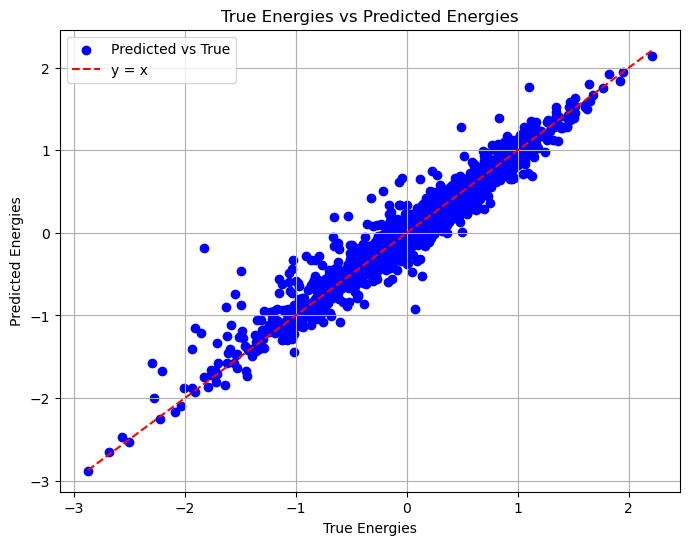

In [33]:
import matplotlib.pyplot as plt

# Initialize lists to store the true and predicted energies
true_energies = []
predicted_energies = []

# Assuming you already have a loop where you calculate these values
for properties in validation:
    species = properties['species'].to(device)
    coordinates = properties['coordinates'].to(device).float()
    _, predicted_energies_batch = model((species, coordinates))
    
    # Store true and predicted energies
    true_energies_batch = properties['energies'].to(device).float()
    
    for i in range(len(true_energies_batch)):
        true_energy = true_energies_batch[i].item()
        predicted_energy = predicted_energies_batch[i].item()
        
        true_energies.append(true_energy)
        predicted_energies.append(predicted_energy)
        
        # Optional: Print the true and predicted energy for debugging
        print(f"True: {true_energy}, Predicted: {predicted_energy}")

# Plot the true vs predicted energies
plt.figure(figsize=(8, 6))
plt.scatter(true_energies, predicted_energies, color='blue', label='Predicted vs True')
plt.plot([min(true_energies), max(true_energies)], [min(true_energies), max(true_energies)], 'r--', label='y = x')
plt.xlabel('True Energies')
plt.ylabel('Predicted Energies')
plt.title('True Energies vs Predicted Energies')
plt.legend()
plt.grid(True)
plt.show()


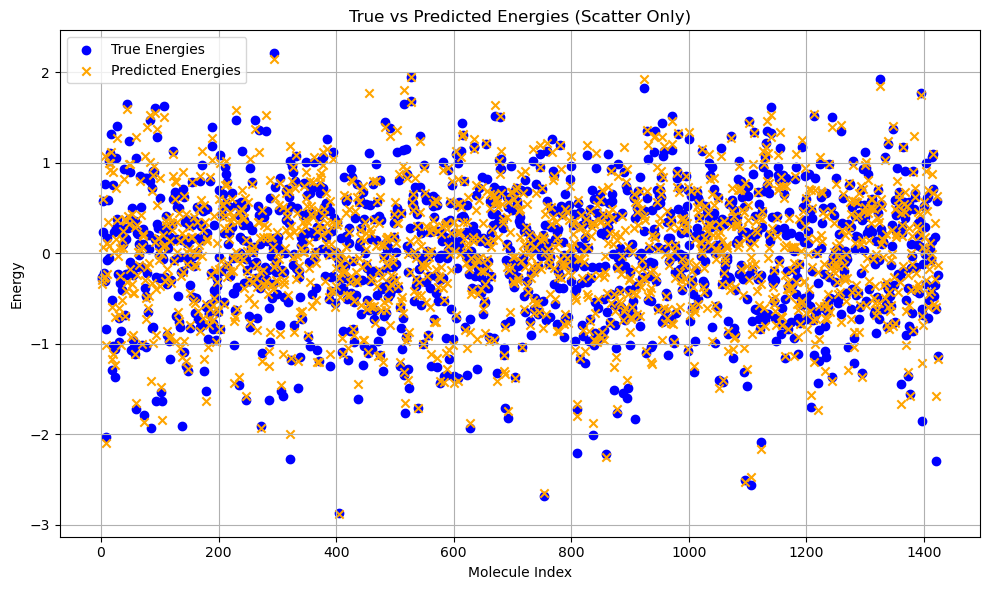

In [35]:
import matplotlib.pyplot as plt

# Lists to store energy values
true_energies = []
predicted_energies = []

# Collect energy data
for properties in validation:
    species = properties['species'].to(device)
    coordinates = properties['coordinates'].to(device).float()
    _, predicted_energies_batch = model((species, coordinates))
    true_energies_batch = properties['energies'].to(device).float()

    for i in range(len(true_energies_batch)):
        true_energy = true_energies_batch[i].item()
        predicted_energy = predicted_energies_batch[i].item()
        true_energies.append(true_energy)
        predicted_energies.append(predicted_energy)

# X-axis: molecule indices
molecule_indices = list(range(1, len(true_energies) + 1))

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(molecule_indices, true_energies, label='True Energies', color='blue', marker='o')
plt.scatter(molecule_indices, predicted_energies, label='Predicted Energies', color='orange', marker='x')

# Labels and formatting
plt.xlabel('Molecule Index')
plt.ylabel('Energy')
plt.title('True vs Predicted Energies (Scatter Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


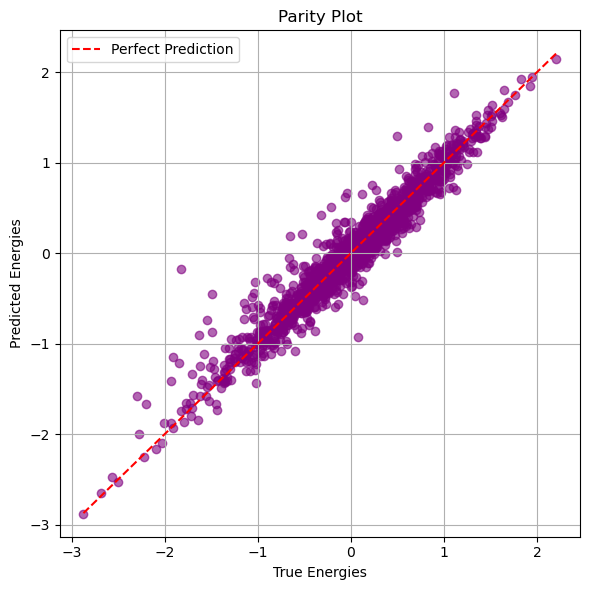

In [36]:
plt.figure(figsize=(6, 6))
plt.scatter(true_energies, predicted_energies, color='purple', alpha=0.6)
plt.plot([min(true_energies), max(true_energies)],
         [min(true_energies), max(true_energies)],
         'r--', label='Perfect Prediction')
plt.xlabel('True Energies')
plt.ylabel('Predicted Energies')
plt.title('Parity Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


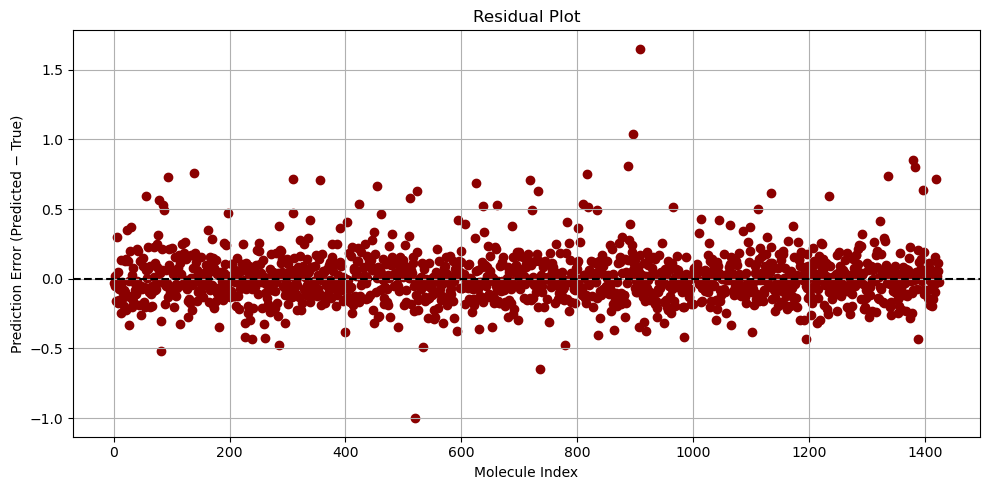

In [37]:
errors = [pred - true for pred, true in zip(predicted_energies, true_energies)]
plt.figure(figsize=(10, 5))
plt.scatter(molecule_indices, errors, color='darkred')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Molecule Index')
plt.ylabel('Prediction Error (Predicted − True)')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()


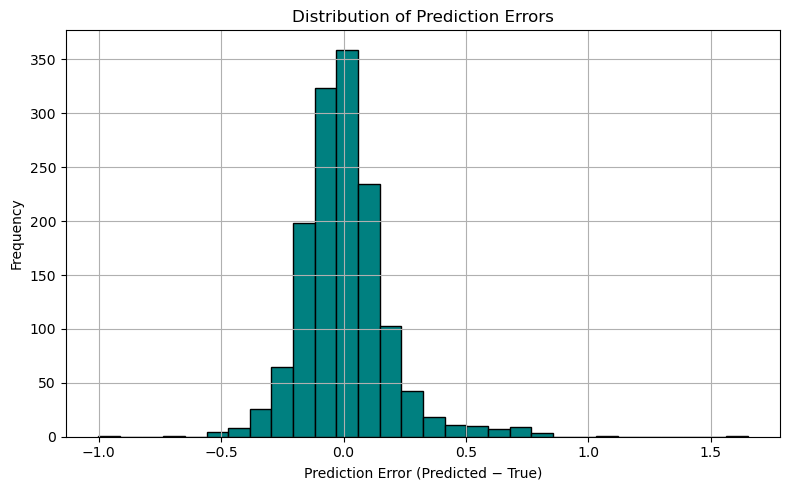

In [38]:
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, color='teal', edgecolor='black')
plt.xlabel('Prediction Error (Predicted − True)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_631753/1973831178.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([true_energies, predicted_energies], labels=['True', 'Predicted'])


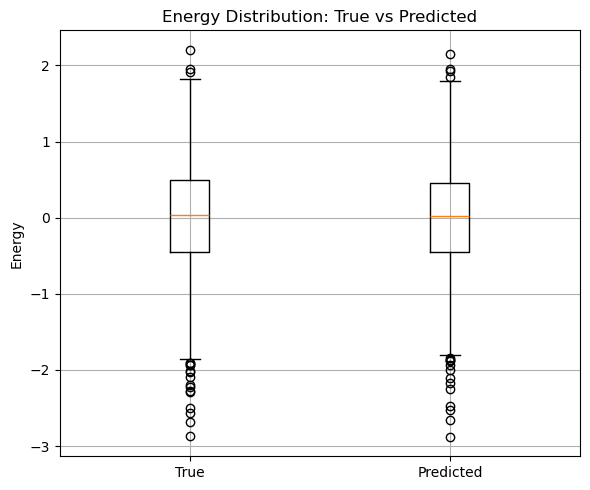

In [39]:
plt.figure(figsize=(6, 5))
plt.boxplot([true_energies, predicted_energies], labels=['True', 'Predicted'])
plt.ylabel('Energy')
plt.title('Energy Distribution: True vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()
